Nome: Luiz Fernando de Barros Caixeta

email: luizfbcaixeta@gmail.com

1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!


In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
from geopy.distance import geodesic 
from scipy.spatial import KDTree
import re
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import string
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from branca.colormap import StepColormap
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Incrementando o dataset

In [3]:
#conhecendo o dataset fornecido 
df = pd.read_csv("dados/Airbnb_NY_data.csv")
df.head(4)


id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0

Em um primeiro momento, vou adicionar variáveis que considero importantes e acredito que agreguem na precificação de um imóvel, principalmente em uma cidade tão grande quanto Nova York (NY).


# 1. Mobilidade urbana

Cidades como NY requerem uma boa mobilidade urbana para melhoria na qualidade de vida tanto dos habitantes locais quanto dos turistas. Devido a isso, acredito que imóveis próximos a estações de metrô tenham um maior valor agregado.

 ### 1.2 Distância entre imóveis e estação de metrô

Para medir a distância dos imóveis em relação as estações de metrô é necessário, em primeira instância, conhecer as coordenadas das estações de NY. Para isso, utilizei os dados GFTS static disponibilizados para desenvolvedores pelo governo de NY em:

https://data.ny.gov/Transportation/MTA-Subway-Entrances-and-Exits-2024/i9wp-a4ja/about_data

Para que seja otimizado o processo de definir qual a menor distância sem a necessidade de comparar todas as estações de metrô a cada vez, é utilizado o algoritmo KDTree. Este algoritmo divide o nosso espaço amostral (localização de todos os pontos de metrô) em grupos. Assim, a posição de um ponto  P(latitude, longitude) de um imóvel é comparada em relação aos grupos e não em relação ao espaço amostral como um todo, otimizando o código e permitindo que a estação mais próxima seja encontrada com facilidade.

**Obs**: os resultados utilizados são apenas uma **estimativa**, uma vez que a distância calculada pelo geopy  não leva em consideração fatores importantes como a geografia e o urbanismo local.

Obs 2: O .query() do KDTree é o responsável por encontrar o ponto mais próximo depois da árvore já estar  montada. Para fazer isso, ele compara os índices na ordem em que são passados, nesse caso: [lat, lon]. Por  padrão ele procura somente o vizinho mais próximo (k = 1) mas é possível procurar quantos forem necessário:

distancias, idx = estacoes_tree.query([lat, lon], k = n); onde n é a quantidade de vizinhos próximos que se quer procurar

 ### 1.3 Distância entre imóveis e pontos de ônibus

 Ainda, é interessante observar também as localizações que possuem pontos de ônibus próximos e, para isso, utilizaremos novamente o método KDTree. Os dados da localização exata dos pontos de ônibus de NY estão disponíveis em:

https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz

In [ ]:
#carrega os dados dos imóveis
imoveis = pd.read_csv("dados/Airbnb_NY_data.csv") 

In [ ]:
#carrega os dados das estações de metrô
estacoes = pd.read_csv("dados/MTA_Subway_Entrances_and_Exits__2024_20250129.csv")

In [ ]:
#carrega os dados dos pontos de ônibus
ponto_onibus = pd.read_csv("dados/Bus_Stop_Shelter_20250201 - Bus_Stop_Shelter_20250201.csv")

In [ ]:
#função para calcular a menor distância dos imóveis em relação ao metrô e ao ponto de ônibus
def calcular_distancia(latitudes_imoveis, longitudes_imoveis, latitudes_pontos, longitudes_pontos):

    #cria o KDTree que será usado para alocar a latitude e longitude das estações de metrô e pontos de ônibus
    pontos_tree = KDTree(np.c_[latitudes_pontos, longitudes_pontos])
    
    #lista para armazenar as distâncias calculadas
    distancias = []
    
    #itera sobre a coordenadas do imóveis P(latitude, longitude)
    for lat, lon in zip(latitudes_imoveis, longitudes_imoveis):

        _, idx               = pontos_tree.query([lat, lon])                        #para encontrar o ponto mais próximo 
        lat_ponto, lon_ponto = latitudes_pontos[idx], longitudes_pontos[idx]        #coordenadas do ponto mais próximo
        distancia            = geodesic((lat, lon), (lat_ponto, lon_ponto)).meters  #calcula a distância usando o geodesic (em metros)

        distancias.append(distancia)                                                #salva as distâncias calculadas na lista 'distancias'
    
    return distancias

#função para eliminar sinais desnecessários e garantir que os dados da estação de metrô e ponto de ônibus estão no formato correto
def limpar_coordenadas(df, col_lat, col_lon):
    
    #remove possíveis formatos em branco 
    df[col_lat] = df[col_lat].astype(str).str.strip().str.replace(r"(\d+)\.(\d+)\.(\d+)", r"\1.\2\3", regex = True)
    df[col_lon] = df[col_lon].astype(str).str.strip().str.replace(r"(\d+)\.(\d+)\.(\d+)", r"\1.\2\3", regex = True)
    
    #converte as strings para numérico e elimna possíveis valores incorretos
    df[col_lat] = pd.to_numeric(df[col_lat], errors = "coerce")
    df[col_lon] = pd.to_numeric(df[col_lon], errors = "coerce")
    
    #remove linhas com valor NaN
    df = df.dropna(subset = [col_lat, col_lon])
    
    #garante que a coordenada de latitude e longitude estejam no intervalo correto: latitude => (-90, 90) e longitude => (-180, 180)
    df = df[(df[col_lat].between(-90, 90)) & (df[col_lon].between(-180, 180))]
    
    return df

#aplica a função limpar_coordenadas no arquivo estacoes e no arquivo ponto_onibus
estacoes     = limpar_coordenadas(estacoes, "Entrance Latitude", "Entrance Longitude")  
ponto_onibus = limpar_coordenadas(ponto_onibus, "Latitude", "Longitude") 

#seleciona as coordenadas dos imoveis 
latitude_imoveis  = df["latitude"].values  
longitude_imoveis = df["longitude"].values  

#calcula a distância de cada imóvel até a estação de metrô mais próxima a ele 
df["distancia_metro"] = calcular_distancia(latitude_imoveis, longitude_imoveis, estacoes["Entrance Latitude"].values, estacoes["Entrance Longitude"].values)

#calcula a distância de cada imóvel até o ponto de ônibus mais próxima a ele 
df["distancia_onibus"] = calcular_distancia(latitude_imoveis, longitude_imoveis, ponto_onibus["Latitude"].values, ponto_onibus["Longitude"].values)

#salva o resultado
df.to_csv("dados/Airbnb_NY_data+.csv", index = False)

print("Etapa concluída!")


Etapa concluída!


## 2. Quantidade de quartos e banheiros 

Agora, vamos utilizar a coluna "nome" para extrair dois dados importantes no processo de pecificação de um imóvel: a quantidade de quartos e banheiros. Para isso, vamos utilizar lógica RegeX e definir padrões para assim determinarmos a quantidade de cada um dos parâmetros. Além disso, é necessário considerar que alguns usuários possuem o costume de escrever de maneira abreviada ou cometem erros de digitação, como por exemplo:

"Cozy 1BD on Central Park West in New York City"

possui um tipo de abreviação comum que deve ser considerada.

Além disso, foi atribuída a lógica de que a maioria dos apartamentos ou casa possuem um banheiro, mesmo nos casos em que se trata de um estúdio. Assim, o código sempre considera que existe ao menos um banheiro. Quanto aos quartos, o código sempre considera que existe 1 quarto, exceto quando é tipo que existe mais de um ou quando o 'room_type' for um 'Private room' pois, neste tipo de imóvel normalmente não há quartos, apenas um espaço comum.

In [ ]:
#função para eliminar alguns números presentes em "nomes" que podem nos atrapalhar 
def limpando_numero(text):
    return re.sub(r'\b[6-9]\d{2,}\b', '', text)

#função para extrair a quantidade de quartos e banheiros das strings presentes na columa "nome"
def extract_rooms_baths(nome):

    #se o título não for uma string, transforma em uma string vazia
    if not isinstance(nome, str):
        nome = ""

    #alguns nomes possuem números muito grande que estão atrapalhando a análise, para removê-los:
    nome = re.sub(r'#?\b\d{3,}\w*\b', '', nome)
    nome = re.sub(r'\b\d+\s*(sq\s*ft|ft²|square feet|m²|meters|sqft)\b', '', nome, flags=re.IGNORECASE) #remove medidas

    #define a lógica para procurar o número de quartos e de banheiros 
    bedroom_pattern  = r'\b([1-5])(?:\.\d+)?\s*[-]?\s*(?:BR|Bd|Bdr|Bdrm|bed|bedrm|bedrms|badroom|B\b|bedroom|bedrooms)\b'
    bathroom_pattern = r'\b([1-5])(?:\.\d+)?\s*[-]?\s*(?:BA|bth|bthr|bthrms|bthrm|baths|bathr|bethroom|barthroom|bathroom|bathsrooms)\b'

    #procura por quartos
    bedrooms_match = re.search(bedroom_pattern, nome, re.IGNORECASE)
    if bedrooms_match:
        bedrooms = int(bedrooms_match.group(1) or bedrooms_match.group(2))
    else:
        bedrooms = 0

    #procura por banheiros 
    bathrooms_match = re.search(bathroom_pattern, nome, re.IGNORECASE)
    bathrooms       = int(bathrooms_match.group(1)) if bathrooms_match and bathrooms_match.group else 1 #caso nada seja dito, o número de banheiros é 1

    #se bathrooms > 1 e bedrooms = 0, então bedrooms = 1
    if bathrooms > 1 and bedrooms == 0:
        bedrooms = 1

    return bedrooms, bathrooms


#converte a coluna 1 (nomes)
df.iloc[:, 1] = df.iloc[:, 1].astype(str).fillna("")

#aplica a função extract_rooms_baths(nome) no arquivo e cria novas colunas
df["quartos"], df["banheiros"] = zip(*df.iloc[:, 1].apply(extract_rooms_baths))

#regra para room_type: Private room sempre tem 0 quartos, a menos que detecte algo, o restante sempre tem 1 quarto, exceto se detectar algo
correcao_quartos = []
for i in range(len(df)):
    room_type = df.loc[i, "room_type"]
    quartos   = df.loc[i, "quartos"]

    if room_type == "Private room" and quartos == 0:
        correcao_quartos.append(0)
    elif room_type != "Private room" and quartos == 0:
        correcao_quartos.append(1)
    else:
        correcao_quartos.append(quartos)

df["quartos"] = correcao_quartos

df.to_csv("dados/Airbnb_NY_data+.csv", index = False)

print("Etapa concluída!")


Etapa concluída!


Para ver se a etapa foi concluída corretamente:

In [ ]:
df = pd.read_csv("dados/Airbnb_NY_data+.csv")

df.iloc[62]

id                                                                    16326
nome                             Comfortable 4-bedroom apt in family house.
host_id                                                               63588
host_name                                                           Dimitri
bairro_group                                                       Brooklyn
bairro                                                     Prospect Heights
latitude                                                           40.67811
longitude                                                         -73.96428
room_type                                                   Entire home/apt
price                                                                   200
minimo_noites                                                            30
numero_de_reviews                                                       143
ultima_review                                                    2019-01-26
reviews_por_

## 3. Taxa de criminalidade

Outro dado importante na precificação de um imóvel é a taxa de crimes cometidos em determinada região. Para analisar a influência dessa variável, foi necessário encontrar o registro de taxas de crimes em 2023 por bairro, obtido em: 

https://www.nyc.gov/site/nypd/stats/crime-statistics/historical.page

Neste link é possível encontrar a quantidade de crimes delatada por Precinct (PTC), que seria o análogo as delegacias brasileiras. Então, com esses dados, é necessário relacionar cada PCT com o seu respectivo bairro, o que foi feito utilizando os dados disponíveis em:

https://www.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page

Assim, foi feito um arquivo de quantidade de ocorrências registradas em cada bairro, podendo então classificar o quão seguro cada um é.

In [ ]:
#carrega o arquivo com a quantidade de crimes por PTC
df_crimes_por_PTC = pd.read_csv('dados/crimes_por_PTC.csv', encoding = 'utf-8-sig')

df_crimes_por_PTC.head(4)

1  TOTAL SEVEN MAJOR FELONY OFFENSES  1889
0  5  TOTAL SEVEN MAJOR FELONY OFFENSES  1252
1  6  TOTAL SEVEN MAJOR FELONY OFFENSES  2067
2  7  TOTAL SEVEN MAJOR FELONY OFFENSES  1193
3  9  TOTAL SEVEN MAJOR FELONY OFFENSES  1715

In [ ]:
#carrega o arquivo com a relação entre o PTC e os bairros
df_PTC_por_bairros = pd.read_csv('dados/PTC_por_bairros.csv', encoding = 'utf-8-sig')

df_PTC_por_bairros.head(4)

Bairro  Precinct
0  Manhattan         1
1  Manhattan         5
2  Manhattan         6
3  Manhattan         7

In [ ]:
try:
    #renomeia as colunas
    df_crimes_por_PTC.columns = ['PTC', 'CRIME', 'TOTAL DE CRIMES']
    df_PTC_por_bairros.columns = ['BAIRRO', 'PTC']

    #converte os dados da coluna PTC em numérico para os dois arquivos
    df_crimes_por_PTC['PTC']  = pd.to_numeric(df_crimes_por_PTC['PTC'], errors  = 'coerce')
    df_PTC_por_bairros['PTC'] = pd.to_numeric(df_PTC_por_bairros['PTC'], errors = 'coerce')
    
    #mescla (merge) os dois arquivos usando a coluna PTC como parâmetro 
    df_final = df_PTC_por_bairros.merge(df_crimes_por_PTC, on = 'PTC', how = 'left').fillna(0)

    #agrupa por bairro e soma os crimes 
    df_resultado = df_final.groupby('BAIRRO', as_index = False)['TOTAL DE CRIMES'].sum().reset_index()

   #mescla o dataset inteiro com o df_resultado
    df_final_merged = df.merge(df_resultado, left_on = 'bairro_group', right_on = 'BAIRRO', how = 'left').fillna({'TOTAL DE CRIMES': 0})

    #remove a coluna 'BAIRRO' e a coluna 'index'
    df_final_merged.drop('BAIRRO', axis = 1, inplace = True)
    df_final_merged.drop('index', axis = 1, inplace = True)

    #salva
    df_final_merged.to_csv('dados/Airbnb_NY_data+.csv', index = False, encoding = 'utf-8-sig')

    print("Etapa concluída!")

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

print(df.columns)



Etapa concluída!
Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_metro', 'distancia_onibus', 'quartos', 'banheiros'],
      dtype='object')


In [ ]:
df1 = pd.read_csv("dados/Airbnb_NY_data+.csv")

In [14]:
print(df1.columns)

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'distancia_metro', 'distancia_onibus', 'quartos', 'banheiros',
       'TOTAL DE CRIMES'],
      dtype='object')


Para avaliar a taxa de criminalidade em cada bairro, é necessário levar em consideração a população do bairro para que seja possível calcular a quantidade de crimes para cada 1000 habitantes.

{

    Manhattan:     1694251
    Queens:        2405464
    Bronx:         1472654
    Brooklyn:      2736074
    Staten Island: 495747

}

dados obtidos por meio do censo demográfico de 2020, disponível em:

https://data.census.gov/

In [ ]:
df1 = pd.read_csv("dados/Airbnb_NY_data+.csv")

populacao_por_bairro_group = {
    "Manhattan":1694251,
    "Brooklyn": 2736074,
    "Queens": 2405464,
    "Bronx": 1472654,
    "Staten Island": 495747
}

#cria uma nova coluna com a população total de cada bairro_group
df1['populacao_total'] = df1['bairro_group'].map(populacao_por_bairro_group)

#calcula a quantidade de crime para cada 1000 habitantes
df1['taxa_de_crimes'] = (df1['TOTAL DE CRIMES'] / df1['populacao_total']) * 1000

#salva o arquivo atualizado
df1.to_csv("Airbnb_NY_data+.csv", index = False)

print("Etapa concluída!")

Etapa concluída!


In [16]:
#dataset com as novas colunas adicionadas

df1 = pd.read_csv("Airbnb_NY_data+.csv", index_col = 0)

df1.head(4)

nome  host_id    host_name  \
id                                                                             
2595                             Skylit Midtown Castle     2845     Jennifer   
3647               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
3831                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
5022  Entire Apt: Spacious Studio/Loft by central park     7192        Laura   

     bairro_group        bairro  latitude  longitude        room_type  price  \
id                                                                             
2595    Manhattan       Midtown  40.75362  -73.98377  Entire home/apt    225   
3647    Manhattan        Harlem  40.80902  -73.94190     Private room    150   
3831     Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt     89   
5022    Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt     80   

      minimo_noites  ...  reviews_por_mes calculado_host_listings_count  \
id                   ...                                                  
2595              1  ...             0.38                             2   
3647              3  ...              NaN                             1   
3831              1  ...             4.64                             1   
5022             10  ...             0.10                             1   

      disponibilidade_365  distancia_metro  distancia_onibus  quartos  \
id                                                                      
2595                  355        88.931513        212.581914        1   
3647                  365       307.575704        271.149398        0   
3831                  194       404.434126         61.817339        1   
5022                    0       177.500234        127.734699        1   

      banheiros  TOTAL DE CRIMES  populacao_total  taxa_de_crimes  
id                                                                 
2595          1          23563.0          1694251       13.907621  
3647          1          23563.0          1694251       13.907621  
3831          1          32353.0          2736074       11.824607  
5022          1          23563.0          1694251       13.907621  

[4 rows x 22 columns]

# Tratando o dataset para iniciar a análise

Agora, com todos os dados em mãos, vamos fazer ma análise exploratória dos dados. Para isso, verificaremos se existem dados duplicados, se existem dados nulos e confirmar se estão no tipo correto.


In [17]:
#verifica a existência de dados nulos e a quantidade para cada coluna
df1.isnull().sum()

nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
distancia_metro                      0
distancia_onibus                     0
quartos                              0
banheiros                            0
TOTAL DE CRIMES                      0
populacao_total                      0
taxa_de_crimes                       0
dtype: int64

In [18]:
#corrige as variáveis nulas 
df1[['nome', 'host_name']] = df1[['nome', 'host_name']].fillna("sem nome")
df1['reviews_por_mes']     = df1['reviews_por_mes'].fillna(0)

print(f"Duplicatas encontradas: {df1.duplicated().sum()}")
print(df1.dtypes)

Duplicatas encontradas: 0
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
distancia_metro                  float64
distancia_onibus                 float64
quartos                            int64
banheiros                          int64
TOTAL DE CRIMES                  float64
populacao_total                    int64
taxa_de_crimes                   float64
dtype: object


In [19]:
#corrigindo o tipo de algumas colunas 
#df1["id"]              = df1["id"].astype(str)
df1["host_id"]         = df1["host_id"].astype(str)
df1["TOTAL DE CRIMES"] = pd.to_numeric(df1["TOTAL DE CRIMES"]).astype("Int64")
df1['price']           = df1['price'].astype(float)
df1['ultima_review'] = pd.to_datetime(df['ultima_review'], format='%Y-%m-%d')
df1['numero_de_reviews'] = pd.to_numeric(df1['numero_de_reviews'], errors='coerce')

# Questão 1 - análise exploratória dos dados:

### Explorando a distribuição de imóveis em função da latitude e longitude 

In [20]:
#agrupar por "bairro_group" e contar as ocorrências
contagem_bairro_group         = df1['bairro_group'].value_counts().reset_index()
contagem_bairro_group.columns = ['bairro_group', 'count'] #renomeia as colunas 

#ordenando em ordem decrescente
contagem_bairro_group_ordenada = contagem_bairro_group.sort_values(by = 'count', ascending = False)

contagem_bairro_group_ordenada

bairro_group  count
0      Manhattan  21661
1       Brooklyn  20103
2         Queens   5666
3          Bronx   1091
4  Staten Island    373

In [21]:
#para filtrar os bairro_group Manhattan e Brooklyn
df1_filtrado = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn'])]

#agrupa por 'bairro_group', 'bairro' e conta as ocorrências de cada um 
contagem_bairro = df1_filtrado.groupby(['bairro_group', 'bairro']).size().reset_index(name='count')

#ordem em ordem decrescente
contagem_bairro_ordeanada = contagem_bairro.sort_values(by = 'count', ascending = False)

contagem_bairro_ordeanada

bairro_group              bairro  count
45     Brooklyn        Williamsburg   3920
2      Brooklyn  Bedford-Stuyvesant   3714
57    Manhattan              Harlem   2658
10     Brooklyn            Bushwick   2465
76    Manhattan     Upper West Side   1971
..          ...                 ...    ...
63    Manhattan         Marble Hill     12
4      Brooklyn        Bergen Beach     10
32     Brooklyn     Manhattan Beach      8
40     Brooklyn            Sea Gate      7
34     Brooklyn          Mill Basin      4

[79 rows x 3 columns]

O primeiro e segundo bairro com maior quantidade de imóveis disponíveis pertencem ao bairro_group Brooklyn, sendo estes: Williamsburg e Bedford-Stuyvesant. Isso é interessante pois mesmo possuindo os dois primeiros bairros com imóveis disponíveis, o bairro_group Manhattan ainda possui uma quantidade total maior.

In [22]:
#função para plotar o histograma 
def plot_histogram(df1, coluna, ax, color = "brown", bins = 30):

    #define a coluna, quantidade de bins, eixos e cor
    sns.histplot(df1[coluna], bins = bins, kde = True, ax = ax, color = color)

    #da nome ao título e rótulo aos eixos x e y 
    ax.set_title(f"Distribuição = {coluna.capitalize()}", fontsize = 12, fontweight = 'bold')
    ax.set_xlabel(coluna.capitalize())
    ax.set_ylabel("frequência")

    #cor de fundo 
    ax.set_facecolor("#eaeaea")

    #adiciona estilização ao grid 
    ax.grid(True, linestyle = "--", color="#aaaaaa", alpha = 1.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [23]:
#o objetivo dessa função é gerar um esquema de cores que seja baseado na frequência, gerando um padrão a ser seguido pela função de scatter e de gráfico de barras
def generate_color_mapping(df1, col_bairro, palette = "Dark2"):

    #conta a quantidade de imóveis por bairro e ordena em ordem decrescente
    bairro_counts = df1[col_bairro].value_counts().sort_values(ascending = False)

    #pega a paleta de cores e seleciona as primeiras disponíveis
    palette_colors = sns.color_palette(palette, n_colors = len(bairro_counts))

    #mapeia os bairros para cores baseadas na ordem de 'bairro_counts'
    bairro_colors = {bairro: palette_colors[i] for i, bairro in enumerate(bairro_counts.index)}

    return bairro_colors, bairro_counts

In [24]:
#função para plotar um gráfico de dispersão usando scatter
def plot_scatter_distribution(df1, x_col, y_col, col_bairro, ax, bairro_colors, bairro_counts):

    #estiliza o scatter
    scatter = sns.scatterplot(
        data      = df1, 
        x         = x_col,
        y         = y_col,
        hue       = col_bairro,
        palette   = bairro_colors,
        alpha     = 0.6,
        edgecolor = 'white',
        ax        = ax,
        s         = 15
    )

    #da nome ao título e rótulo aos eixos x e y 
    ax.set_title(f"distribuição de {y_col} por {x_col}", fontweight = 'bold')
    ax.set_xlabel(x_col.capitalize())
    ax.set_ylabel(y_col.capitalize())


    #adiciona estilização ao grid
    ax.grid(True, linestyle = "--", color = "#aaaaaa", alpha = 1.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    #cor de fundo
    ax.set_facecolor("#eaeaea")

    #personalizando a legenda para adicionar a contagem a ela
    handles, labels = scatter.get_legend_handles_labels()
    new_labels      = [f"{bairro} : {bairro_counts[bairro]}" for bairro in labels if bairro in bairro_counts]

    ax.legend(handles = handles, labels = new_labels, title = "Bairro : frequência", loc = 'upper left')

In [25]:
#função para plotar gráfico de barras para comparação
def plot_bar_chart(df1, col_bairro, ax, bairro_colors, bairro_counts):

    #ordena o df1 para corresponder a ordem das cores 
    bairro_counts_df1 = bairro_counts.reset_index()
    bairro_counts_df1.columns = [col_bairro, "Imóveis disponíveis"]

    #para que as cores sigam a mesma ordem do scatter
    palette_list = [bairro_colors[bairro] for bairro in bairro_counts_df1[col_bairro]]

    #para estilizar o barplot
    sns.barplot(
        x       = col_bairro,
        y       = "Imóveis disponíveis",
        data    = bairro_counts_df1,
        palette = palette_list,
        ax      = ax
    )

    #define o título, o rótulo dos eixos e os inclina em 45º para estilizar
    ax.set_title("imóveis por bairro", fontsize=12, fontweight='bold')
    ax.set_xlabel("bairro")
    ax.set_ylabel("imóveis disponíveis")
    ax.tick_params(axis='x', rotation=45)

    #estiliza o grid
    ax.grid(axis="y", linestyle="--", color="#aaaaaa", alpha=1.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    #cor de fundo
    ax.set_facecolor("#eaeaea")

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


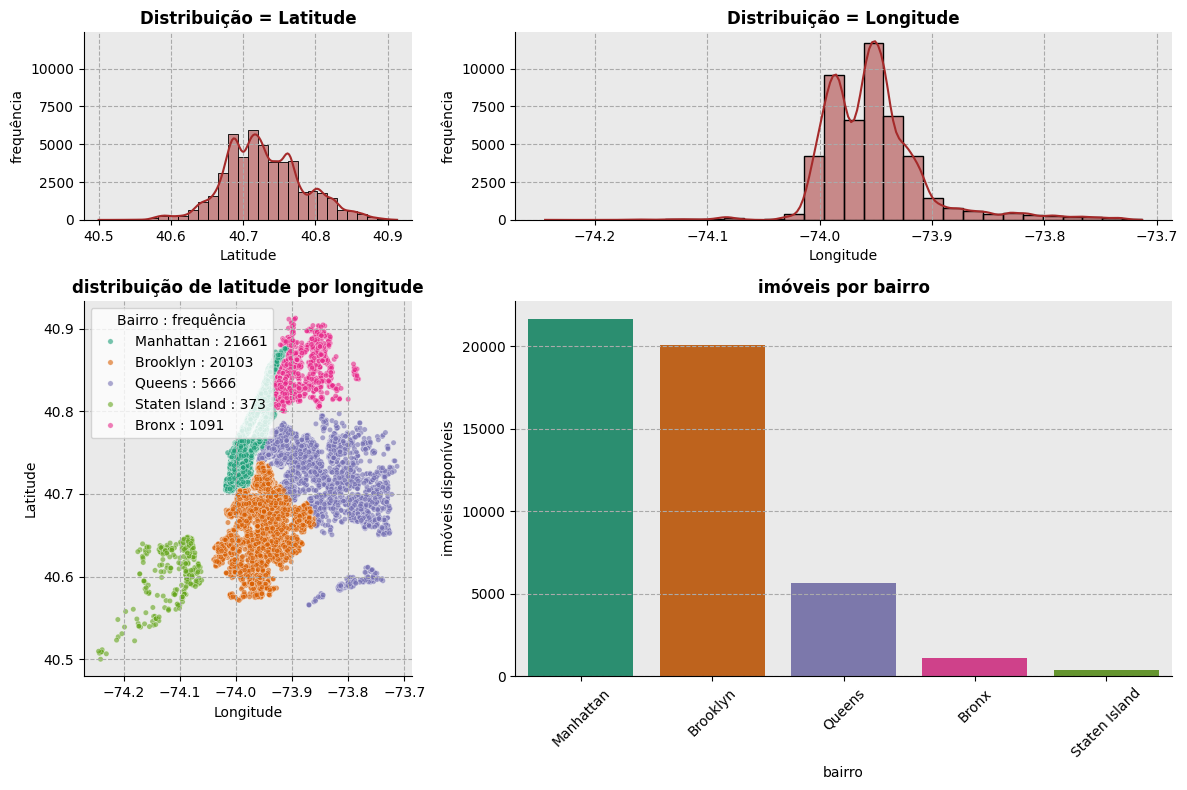

In [26]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8), gridspec_kw = {'height_ratios': [1, 2], 'width_ratios': [1, 2]})

#gerando histogramas para latitude e longitude
plot_histogram(df1, "latitude", axes[0, 0])
plot_histogram(df1, "longitude", axes[0, 1])

#ajustando o eixo y dos histogramas para a mesma escala para facilitar a comparação
y_lim = max(axes[0, 0].get_ylim()[1], axes[0, 1].get_ylim()[1])
axes[0, 0].set_ylim(0, y_lim)
axes[0, 1].set_ylim(0, y_lim)

#mapeando as cores para plotar os gráficos de scatter e barras
bairro_colors, bairro_counts = generate_color_mapping(df1, "bairro_group")

#plotando o gráfico de scatter 
plot_scatter_distribution(df1, "longitude", "latitude", "bairro_group", axes[1, 0], bairro_colors, bairro_counts)

#gerando o gráfico de barras com as mesmas cores do scatter
plot_bar_chart(df1, "bairro_group", axes[1, 1], bairro_colors, bairro_counts)


plt.tight_layout()
plt.show()


Agora vamos analisar a distribuição da quantidade de imóveis dentro dos bairro_group:

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


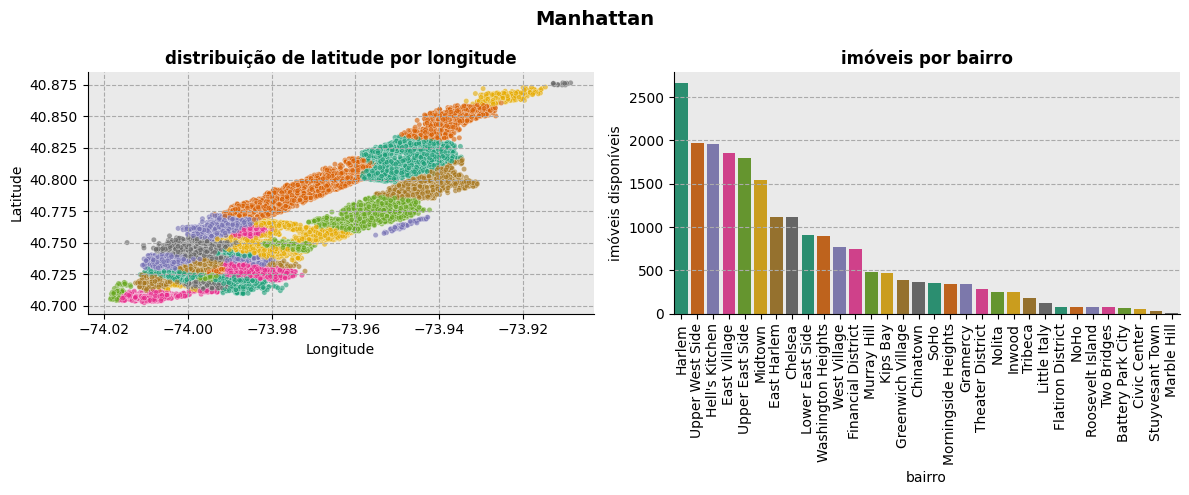

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


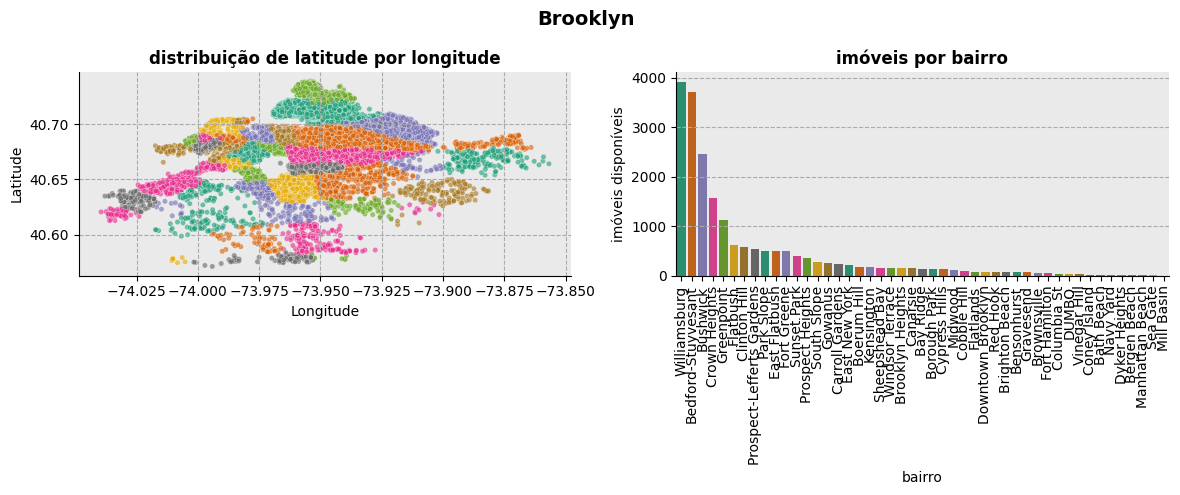

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


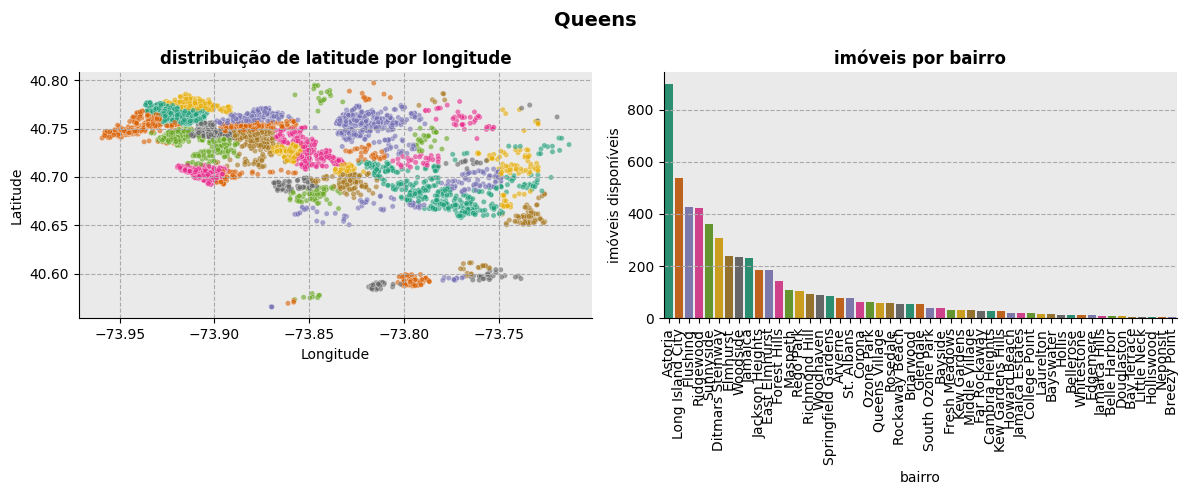

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


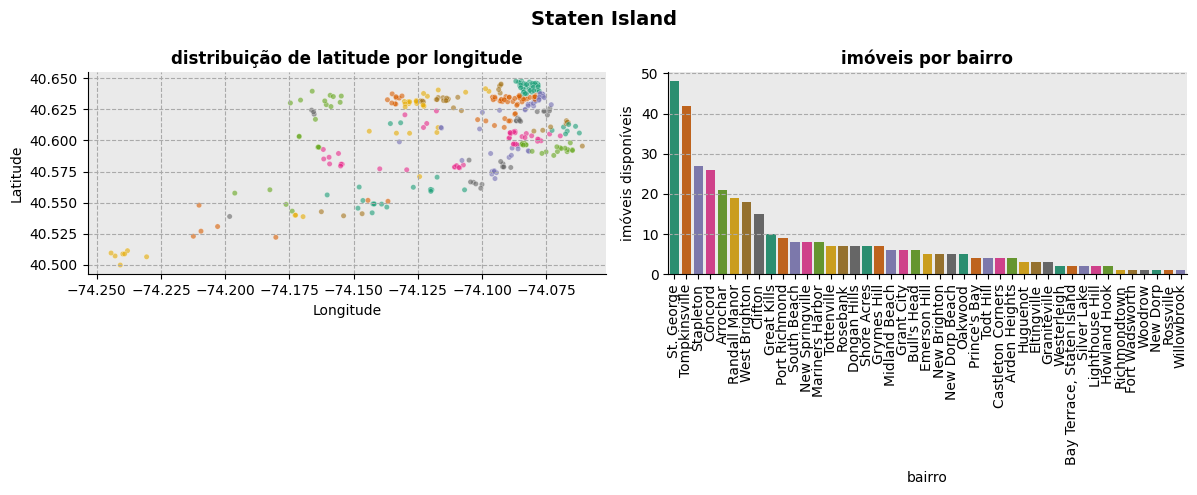

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\230095232.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


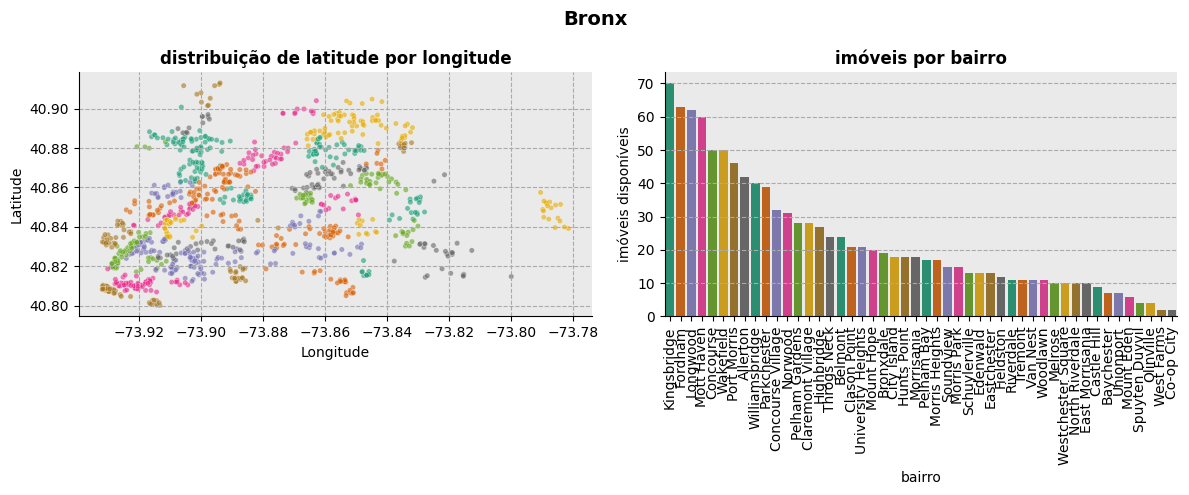

In [27]:
#para plotar o scatter e gráfico de barras dos bairros
def plot_bairros_por_grupo(df1, col_bairro_group = "bairro_group", col_bairro = "bairro"):

    grupos = df1[col_bairro_group].unique()

    for grupo in grupos:

        #filtra os bairros que pertencem ao bairro_group
        df1_filtrado = df1[df1[col_bairro_group] == grupo]

        #quando terminar de filtrar um bairro_group repete o processo 
        if df1_filtrado.empty:
            continue 
        
        #seleciona a cor que vai ser usado para o scatter e o gráfico de barras
        bairro_colors, bairro_counts = generate_color_mapping(df1_filtrado, col_bairro)

        #cria a figura e os subplots
        fig, axes = plt.subplots(1, 2, figsize = (12, 5))

        #plota o scatter
        plot_scatter_distribution(df1_filtrado, "longitude", "latitude", col_bairro, axes[0], bairro_colors, bairro_counts)
        axes[0].legend().remove() #remove a legenda por conta da grande quantidade de bairros

        #plota o gráfico de barras
        plot_bar_chart(df1_filtrado, col_bairro, axes[1], bairro_colors, bairro_counts)
        axes[1].tick_params(axis = "x", rotation = 90) #rotaciona os rótulos em 90 para ficar legível

        #define o título
        plt.suptitle(f"{grupo}", fontsize = 14, fontweight = "bold")

        plt.tight_layout()
        plt.show()

plot_bairros_por_grupo(df1)

### Analisando a distribuição do room_type por bairro_group e bairro

Agora que conhecemos melhor a distribuição geografica dos imóveis, vamos analisar a distribuição do tipo de imóvel. Para isso, vamos acessar a coluna room_type e observar a quantidade de cada um em relação ao seu respectivo bairro_group.

In [28]:
contagem_room_type = df1.groupby(["bairro_group", "room_type"]).size().reset_index(name = 'count')

contagem_room_type

bairro_group        room_type  count
0           Bronx  Entire home/apt    379
1           Bronx     Private room    652
2           Bronx      Shared room     60
3        Brooklyn  Entire home/apt   9559
4        Brooklyn     Private room  10131
5        Brooklyn      Shared room    413
6       Manhattan  Entire home/apt  13199
7       Manhattan     Private room   7982
8       Manhattan      Shared room    480
9          Queens  Entire home/apt   2096
10         Queens     Private room   3372
11         Queens      Shared room    198
12  Staten Island  Entire home/apt    176
13  Staten Island     Private room    188
14  Staten Island      Shared room      9

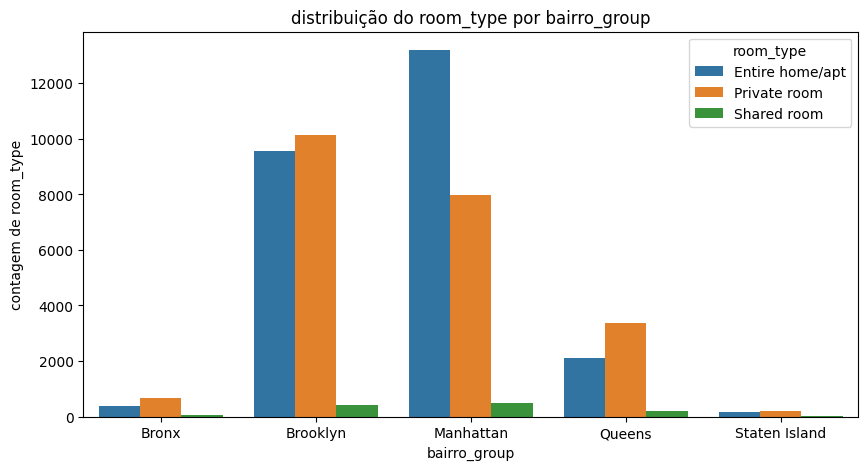

In [29]:
#cria um gráfico de barras mostrando a distribuição do room_type dentro de cada bairro_group
plt.figure(figsize = (10, 5))
sns.barplot(x = 'bairro_group', y = 'count', hue = 'room_type', data = contagem_room_type)

plt.title('distribuição do room_type por bairro_group')
plt.xlabel('bairro_group')
plt.ylabel('contagem de room_type')

plt.legend(title = 'room_type')
plt.show()

Em todos os bairros percebemos uma baixa quantidade de imóveis do tipo Shared room. Enquanto isso, bairros caros como Manhattan e Brooklyn possuem também uma grande quantidade de imóveis do tipo Entire home/apt, o que faz sentido por ser um tipo de imóvel mais caro que os demais.


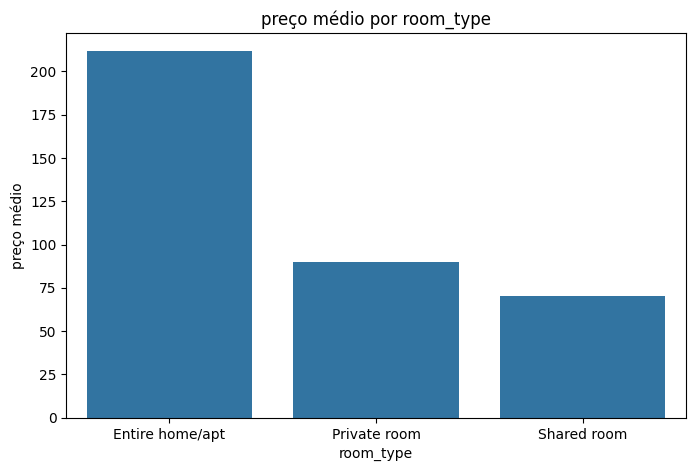

In [30]:
#para calcular o preço médio de cada room_type
preco_medio_room_type = df1.groupby('room_type')['price'].mean().reset_index()

plt.figure(figsize = (8, 5))
sns.barplot(x = 'room_type', y = 'price', data = preco_medio_room_type)

plt.title('preço médio por room_type')
plt.xlabel('room_type')
plt.ylabel('preço médio')

plt.show()


## Analisando a relação entre room_type e a quantidade de quartos

Imóveis com room_type Entire home/apt são aqueles que são mais espaçosos e, consequentemente, possuem uma maior quantidade de quartos. Como o bairro_group possui os imóveis mais caros e também a maior quantidade de Entire home/apt, é esperado que ele possua a maior quantidade média de quartos.

In [31]:
#calcula o valor médio de quartos por bairro
media_quartos_por_bairro = df1.groupby("bairro_group")["quartos"].mean()

#posiciona as médias em ordem decrescente 
media_ordenada = media_quartos_por_bairro.sort_values(ascending = False)
bairro_top     = media_ordenada.idxmax()
media_top      = media_ordenada.max()

print(f"O bairro_group com maior média de quartos é {bairro_top} com {media_top:.2f} quartos")

media_quartos_por_bairro

O bairro_group com maior média de quartos é Manhattan com 0.79 quartos


bairro_group
Bronx            0.494042
Brooklyn         0.650450
Manhattan        0.794839
Queens           0.533004
Staten Island    0.664879
Name: quartos, dtype: float64

Ao calcular a média do número de quartos em Manhattan, percebi que os bairros com maior quantidade de quartos são os que mais se aproximam dos principais pontos turísticos presentes não somente no bairro como também em toda NY. Assim, essa maior quantidade de quartos no bairro_group Manhattan provavelmente se deve ao fato de serem imóveis mais caros e luxuosos. Aqui, segue um mapa de calor da quantidade de quartos em cada imóvel mostrando a correlaçao dessa coluna com a proximidade de alguns dos principais pontos turísticos, como por exemplo: 

- Central Park 
- Times Square 
- Empire State Building
- Museu da arte moderna
- Museu da cidade de NY 
- Museu memorial
- One World Trade Center
- Centro cívico
- Lincoln Center for the Performing Arts

Além do aumento de quartos conforme estamos próximos de pontos turísticos, é interessante notar que a quantidade de quartos também diminui a medida que nos aproximamos do bairro Bronx.

Obs: a latitude e longitude desses pontos turísticos foi extraída diretamente do Google Maps.

In [32]:
##cria um mapa centralizado em Manhattan
#manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12, tiles="cartodbpositron")
#
##define os bairros presentes em bairro_group que serão utilizados
#mapa_df1 = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn'])]
#
##define a escala de cor que será utilizada, além da escala
#colormap = StepColormap(["y", "r", "g", "c", "b", "m"], vmin = 0, vmax = 6)
#colormap.caption = "quantidade de quartos"
#manhattan_map.add_child(colormap)  
#
##adiciona os pontos no mapa 
#for index, row in mapa_df1.iterrows():
#    folium.CircleMarker(
#        location     = [row['latitude'], row['longitude']],
#        radius       = 1,  
#        color        = colormap(row['quartos']),  
#        fill         = True,
#        fill_color   = colormap(row['quartos']),
#        fill_opacity = 0.6,
#    ).add_to(manhattan_map)
#
##adiciona o nome, latitude e longitude de alguns pontos turísiticos para que eles sejam marcados no mapa
#pontos_turisticos = [
#    {"nome": "Central Park", "latitude": 40.785091, "longitude": -73.968285},
#    {"nome": "Times Square", "latitude": 40.758896, "longitude":-73.985130},
#    {"nome": "Empire State Building", "latitude": 40.748817, "longitude": -73.985428},
#    {"nome": "Museu da arte moderna", "latitude": 40.763448, "longitude": -73.977157},
#    {"nome": "Museu da cidade de NY", "latitude": 40.79303, "longitude": -73.95476},
#    {"nome": "Museu memorial", "latitude": 40.71227, "longitude": -74.01511},
#    {"nome": "One World Trade Center", "latitude": 40.71249, "longitude": -74.01198},
#    {"nome": "Centro cívico", "latitude": 40.71412, "longitude": -74.00206},
#    {"nome": "Lincoln Center for the Performing Arts", "latitude": 40.77324, "longitude": 73.98667}
#]
#
##gera a marcação dos pontos turísticos no mapa
#for ponto in pontos_turisticos:
#    folium.Marker(
#        location = [ponto['latitude'], ponto['longitude']],
#        popup = ponto['nome'],
#        icon = folium.Icon(color = 'blue', icon = 'info-sign')
#    ).add_to(manhattan_map)
#
#manhattan_map

## Numero de reviews por bairro_group

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\4096802517.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bairro_group', y='numero_de_reviews', data=reviews_por_bairro, palette='Set2', order=reviews_por_bairro['bairro_group'])


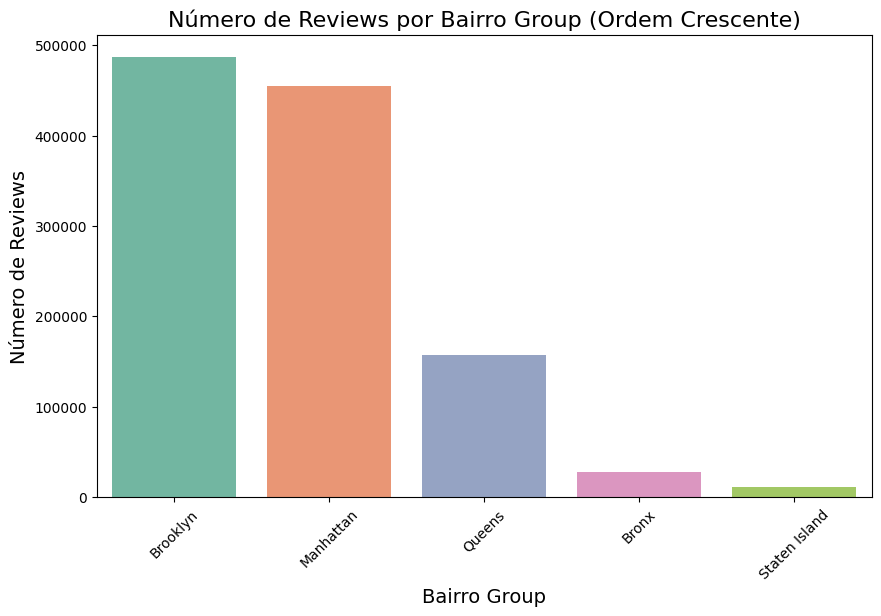

In [33]:
# Agrupando os dados por bairro_group e somando o número de reviews
reviews_por_bairro = df1.groupby('bairro_group')['numero_de_reviews'].sum().reset_index()

# Ordenando os dados pelo número de reviews em ordem crescente
reviews_por_bairro = reviews_por_bairro.sort_values(by='numero_de_reviews', ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura se necessário
sns.barplot(x='bairro_group', y='numero_de_reviews', data=reviews_por_bairro, palette='Set2', order=reviews_por_bairro['bairro_group'])

# Adicionando título e rótulos
plt.title('Número de Reviews por Bairro Group (Ordem Crescente)', fontsize=16)
plt.xlabel('Bairro Group', fontsize=14)
plt.ylabel('Número de Reviews', fontsize=14)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Exibindo o gráfico
plt.show()

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\4075022435.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='numero_de_reviews', data=reviews_por_bairro, palette='Set2', order=reviews_por_bairro['room_type'])


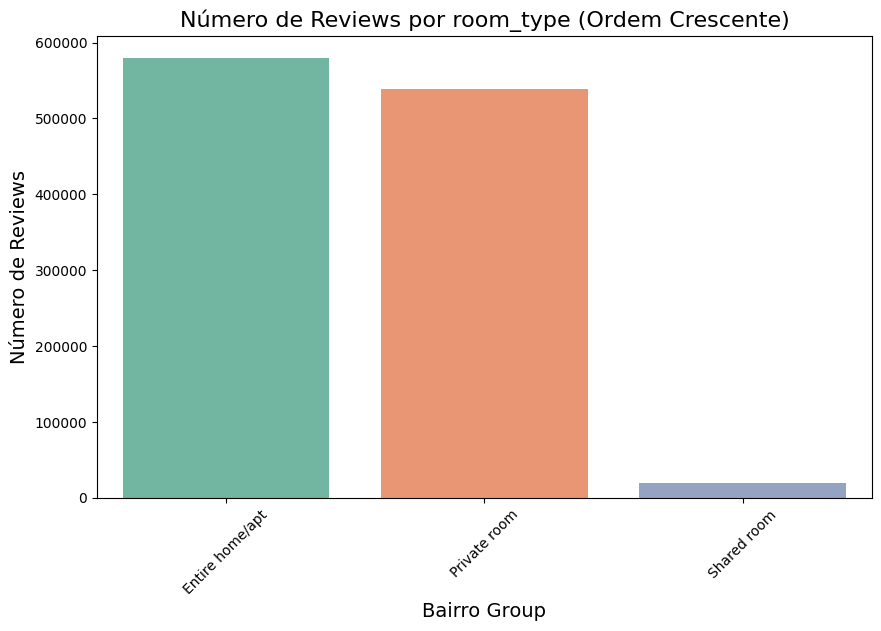

In [34]:
# Agrupando os dados por bairro_group e somando o número de reviews
reviews_por_bairro = df1.groupby('room_type')['numero_de_reviews'].sum().reset_index()

# Ordenando os dados pelo número de reviews em ordem crescente
reviews_por_bairro = reviews_por_bairro.sort_values(by='numero_de_reviews', ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura se necessário
sns.barplot(x='room_type', y='numero_de_reviews', data=reviews_por_bairro, palette='Set2', order=reviews_por_bairro['room_type'])

# Adicionando título e rótulos
plt.title('Número de Reviews por room_type (Ordem Crescente)', fontsize=16)
plt.xlabel('Bairro Group', fontsize=14)
plt.ylabel('Número de Reviews', fontsize=14)
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Exibindo o gráfico
plt.show()

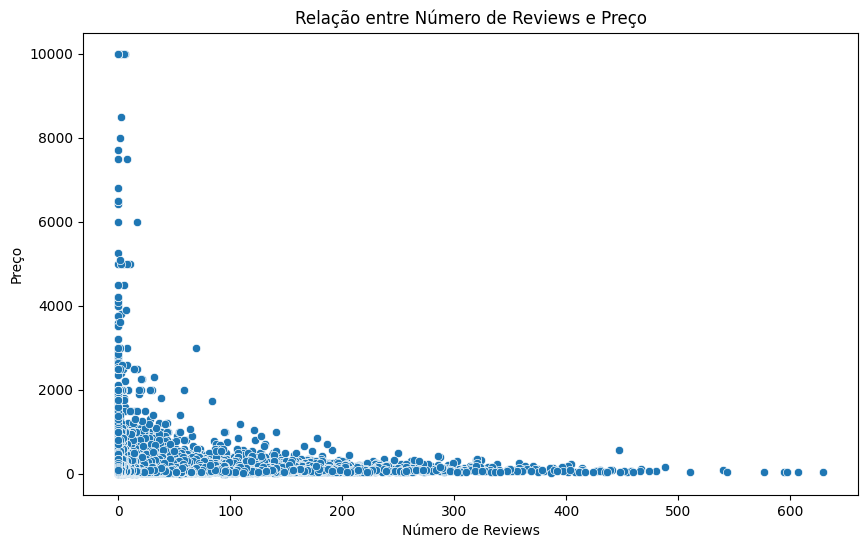

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='numero_de_reviews', y='price', data=df1)
plt.title('Relação entre Número de Reviews e Preço')
plt.xlabel('Número de Reviews')
plt.ylabel('Preço')
plt.show()

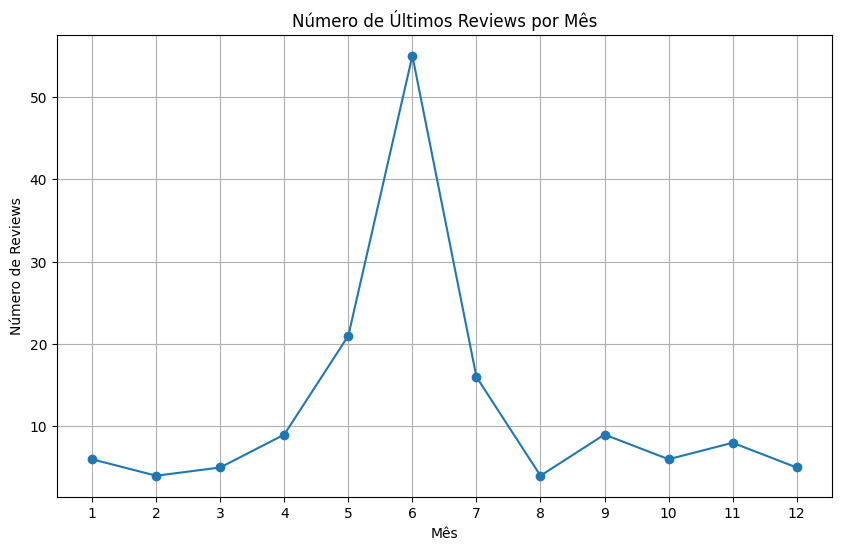

In [36]:
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])

# Passo 3: Extrair o mês de cada data
df1['mes'] = df1['ultima_review'].dt.month

# Passo 4: Contar o número de reviews por mês
reviews_por_mes = df1['mes'].value_counts().sort_index()

# Passo 5: Plotar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(reviews_por_mes.index, reviews_por_mes.values, marker='o', linestyle='-')
plt.title('Número de Últimos Reviews por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Reviews')
plt.xticks(range(1, 13))  # Garantir que todos os meses sejam mostrados no eixo x
plt.grid(True)
plt.show()

As pessoas viajam mais durante o verão para NY (esse dado condiz com as pesquisas recentes)

As pessoas dão mais review quando o preço é menor

# Questão 1 - hipóteses:

### Estudando a precificação

In [37]:
#para conhecer um pouco dos dados
df1.describe()

latitude     longitude         price  minimo_noites  \
count  48894.000000  48894.000000  48894.000000   48894.000000   
mean      40.728951    -73.952169    152.720763       7.030085   
min       40.499790    -74.244420      0.000000       1.000000   
25%       40.690100    -73.983070     69.000000       1.000000   
50%       40.723075    -73.955680    106.000000       3.000000   
75%       40.763117    -73.936273    175.000000       5.000000   
max       40.913060    -73.712990  10000.000000    1250.000000   
std        0.054529      0.046157    240.156625      20.510741   

       numero_de_reviews                  ultima_review  reviews_por_mes  \
count       48894.000000                            148     48894.000000   
mean           23.274758  2018-09-21 15:43:47.027026944         1.090928   
min             0.000000            2015-05-17 00:00:00         0.000000   
25%             1.000000            2018-07-20 12:00:00         0.040000   
50%             5.000000            2019-05-19 12:00:00         0.370000   
75%            24.000000            2019-06-23 00:00:00         1.580000   
max           629.000000            2019-07-05 00:00:00        58.500000   
std            44.550991                            NaN         1.597294   

       calculado_host_listings_count  disponibilidade_365  distancia_metro  \
count                   48894.000000         48894.000000     48894.000000   
mean                        7.144005           112.776169       397.977059   
min                         1.000000             0.000000         0.446800   
25%                         1.000000             0.000000       163.798557   
50%                         1.000000            45.000000       276.335393   
75%                         2.000000           227.000000       435.073419   
max                       327.000000           365.000000      8396.471210   
std                        32.952855           131.618692       570.395269   

       distancia_onibus       quartos     banheiros  TOTAL DE CRIMES  \
count      48894.000000  48894.000000  48894.000000          48894.0   
mean         219.878788      0.697427      1.006136     27627.046284   
min            0.739443      0.000000      1.000000           3230.0   
25%          112.681520      0.000000      1.000000          23563.0   
50%          184.060787      1.000000      1.000000          27604.0   
75%          284.497511      1.000000      1.000000          32353.0   
max         1929.817096      5.000000      5.000000          32353.0   
std          152.894342      0.745863      0.093579      4597.475559   

       populacao_total  taxa_de_crimes         mes  
count     4.889400e+04    48894.000000  148.000000  
mean      2.190931e+06       12.852557    6.304054  
min       4.957470e+05        6.515420    1.000000  
25%       1.694251e+06       11.824607    5.000000  
50%       2.405464e+06       11.824607    6.000000  
75%       2.736074e+06       13.907621    7.000000  
max       2.736074e+06       20.164275   12.000000  
std       5.198554e+05        1.626861    2.462394

- 'price'       : em média, os imóveis possuem o valor de locação em 152.72$; exitem imóveis com o valor de 10.000,00$ que certamente se tratam de imóveis luxuosos e seu valor exorbitante pode   acabar  interferindo nas análies.

- 'minimo_noite': em média, os imóveis possuem o mínimo de noites como sendo 7 dias; existem imóveis com o mínimo de noite muito elevado (mais de 3 anos) e isso pode interferir na análise.

- 'review_por_mes': alguns imóveis possuem menos de uma avaliação por mês.

- 'disponibilidade_365': alguns imóveis não possuem disponibilidade em nenhum dia do ano, podendo já estar locado ou estarem indisponíveis.

- 'distancia_metro': em geral, os imóveis estão localizados próximos a estações de metrô; existe exceção onde o imóvel está a 8.396km da estação.

- 'quartos': a média de quartos é de 0.69 devido a grande ocorrência do 'room_type' Private room, que são acomodações que não possuemo cômodo quarto; existem casas maiores que possuem até cinco quartos

- 'banheiros': foi considerado que até mesmo os 'room_type' Private room possuem ao menos um banheiro, logo, faz sentido que a média do número de banheiros seja próxima de 1.

- 'taxa_de_crimes': indicia a existência de bairros muito mais perigosos que outros.

# Analisando a distribuição de preço dos imóveis 

Vamos analisar a variação do preço dos imóveis nos bairros e, posteriormente, utilizar as demais informações para encontrar as justificativas para os valores. Para termos uma ideia da distribuição de preço nos imóveis

In [38]:
#calcula o valor médio de quartos por bairro
media_quartos_por_bairro = df1.groupby("bairro_group")["quartos"].mean()

#posiciona as médias em ordem decrescente 
media_ordenada = media_quartos_por_bairro.sort_values(ascending = False)
bairro_top     = media_ordenada.idxmax()
media_top      = media_ordenada.max()

print(f"O bairro_group com maior média de quartos é {bairro_top} com {media_top:.2f} quartos")

media_quartos_por_bairro


O bairro_group com maior média de quartos é Manhattan com 0.79 quartos


bairro_group
Bronx            0.494042
Brooklyn         0.650450
Manhattan        0.794839
Queens           0.533004
Staten Island    0.664879
Name: quartos, dtype: float64

- 'price'       : em média, os imóveis possuem o valor de locação em 152.72$; exitem imóveis com o valor de 10.000,00$ que certamente se tratam de imóveis luxuosos e seu valor exorbitante pode   acabar  interferindo nas análies.

- 'minimo_noite': em média, os imóveis possuem o mínimo de noites como sendo 7 dias; existem imóveis com o mínimo de noite muito elevado (mais de 3 anos) e isso pode interferir na análise.

- 'review_por_mes': alguns imóveis possuem menos de uma avaliação por mês.

- 'disponibilidade_365': alguns imóveis não possuem disponibilidade em nenhum dia do ano, podendo já estar locado ou estarem indisponíveis.

- 'distancia_metro': em geral, os imóveis estão localizados próximos a estações de metrô; existe exceção onde o imóvel está a 8.396km da estação.

- 'quartos': a média de quartos é de 0.69 devido a grande ocorrência do 'room_type' Private room, que são acomodações que não possuemo cômodo quarto; existem casas maiores que possuem até cinco quartos

- 'banheiros': foi considerado que até mesmo os 'room_type' Private room possuem ao menos um banheiro, logo, faz sentido que a média do número de banheiros seja próxima de 1.

- 'taxa_de_crimes': indicia a existência de bairros muito mais perigosos que outros.



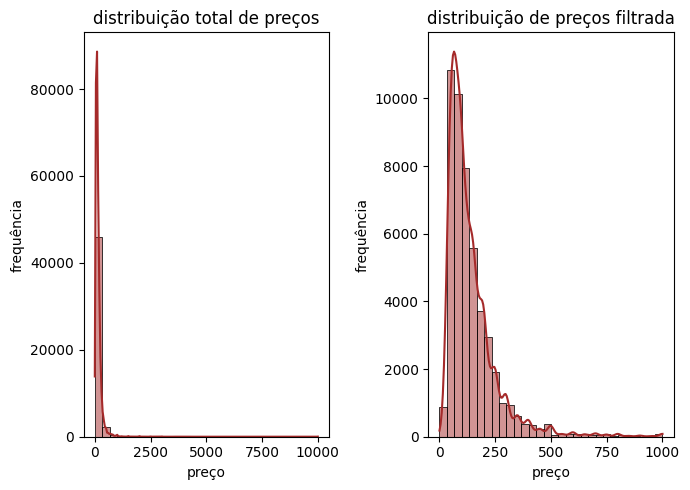

In [39]:
plt.figure(figsize = (7, 5))

#como valores muito altos podem atrapalhar o estudo, vamos restringir 'price'
df1_filtrado = df1[df1['price'] <= 1000]

plt.subplot(1, 2, 1)

#histograma sem nenhum preço filtrado
sns.histplot(df1['price'], bins = 30, kde = True, color = 'brown')
plt.title('distribuição total de preços')
plt.xlabel('preço')
plt.ylabel('frequência')

#histograma com preço filtrado (price <= 1500)
plt.subplot(1, 2, 2)

sns.histplot(df1_filtrado['price'], bins = 30, kde = True, color = 'brown')
plt.title('distribuição de preços filtrada')
plt.xlabel('preço')
plt.ylabel('frequência')

plt.tight_layout()
plt.show()


# 1.1 Tratamento de valores atípicos (outliers)

Existem alguns valores de imóveis que são muito altos em relação a outros e isso pode atrapalhar a análise estatística que faremos. Para termos uma visão melhor dos outliers:

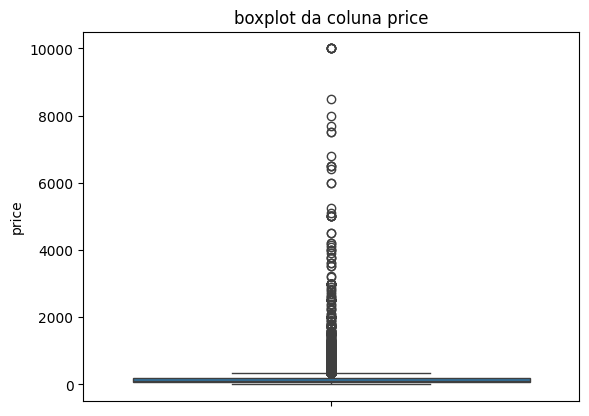

In [40]:
sns.boxplot(y = df1['price'])
plt.title('boxplot da coluna price')
plt.show()

In [41]:
#procura pelos 10 imóveis mais caros 
top_10_caros = df1.nlargest(10, 'price')[['price', 'bairro_group']]
top_10_caros

price bairro_group
id                            
7003697   10000.0       Queens
13894339  10000.0     Brooklyn
22436899  10000.0    Manhattan
4737930    9999.0    Manhattan
9528920    9999.0    Manhattan
31340283   9999.0    Manhattan
23377410   8500.0    Manhattan
2953058    8000.0     Brooklyn
22779726   7703.0    Manhattan
33007610   7500.0    Manhattan

O bairro_group Manhattan aparece 7 vezes na lista de imóveis mais caros.

Calculando os quartis para separar os outliers:

In [42]:
#para calcular os quartis e IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

#para definir os limites dos outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

#para identificar os outliers
outliers = df[(df['price'] < limite_inferior) | (df['price'] > limite_superior)]
outliers.head(4)


id                                               nome  host_id  \
60   15396                 Sunny & Spacious Chelsea Apartment    60278   
84   19601                perfect for a family or small group    74303   
102  23686  2000 SF 3br 2bath West Village private  townhouse    93790   
113  26933  2 BR / 2 Bath Duplex Apt with patio! East Village    72062   

    host_name bairro_group            bairro  latitude  longitude  \
60      Petra    Manhattan           Chelsea  40.74623  -73.99530   
84     Maggie     Brooklyn  Brooklyn Heights  40.69723  -73.99268   
102       Ann    Manhattan      West Village  40.73096  -74.00319   
113     Bruce    Manhattan      East Village  40.72540  -73.98157   

           room_type  price  minimo_noites  numero_de_reviews ultima_review  \
60   Entire home/apt    375            180                  5    2018-11-03   
84   Entire home/apt    800              1                 25    2016-08-04   
102  Entire home/apt    500              4                 46    2019-05-18   
113  Entire home/apt    350              2                  7    2017-08-09   

     reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
60              0.12                              1                  180   
84              0.24                              1                    7   
102             0.55                              2                  243   
113             0.06                              4                  298   

     distancia_metro  distancia_onibus  quartos  banheiros  
60        129.342995        168.095359        1          1  
84         59.844256        111.693785        1          1  
102       135.307051        150.509675        3          1  
113       562.285778        216.778951        2          1

Para remover os outliers:

In [ ]:
#para remover os outliers do df1
df1 = df1[(df1['price'] >= limite_inferior) & (df1['price'] <= limite_superior)]

df1.to_csv("dados/Airbnb_NY_data+.csv")

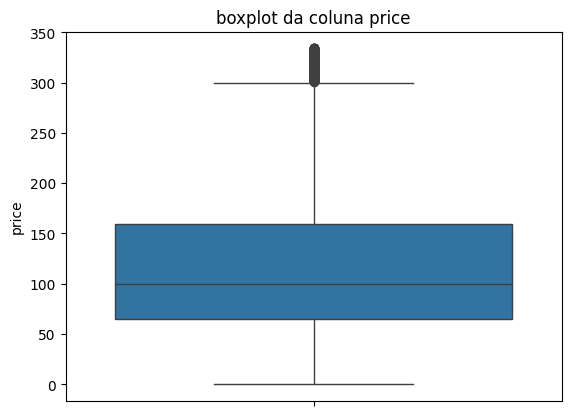

In [44]:
sns.boxplot(y = df1['price'])
plt.title('boxplot da coluna price')
plt.show()

A remoção dos outliers é importate pois, como nosso objetivo final é utilizar um modelo para prever a precificação de um imóvel, valores muito fora da curva podem ser maléficos e acabar reduzinho o desempenho do modelo

Calculando a média, desvio padrão, máximo e mínimo para a cidade de NY utilizando os dados tratados (sem outliers)


estatísticas para NY:
  metrica       valor
0    mean  119.969688
1     std   68.150755
2     min    0.000000
3     max  334.000000
--------------------------------------------------
    bairro_group        mean        std   min    max
0      Manhattan  145.952835  70.473076   0.0  334.0
1       Brooklyn  105.697383  60.938585   0.0  333.0
2  Staten Island   89.235616  57.700147  13.0  300.0
3         Queens   88.904437  53.536041  10.0  325.0
4          Bronx   77.365421  47.110940   0.0  325.0


C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\1639041467.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


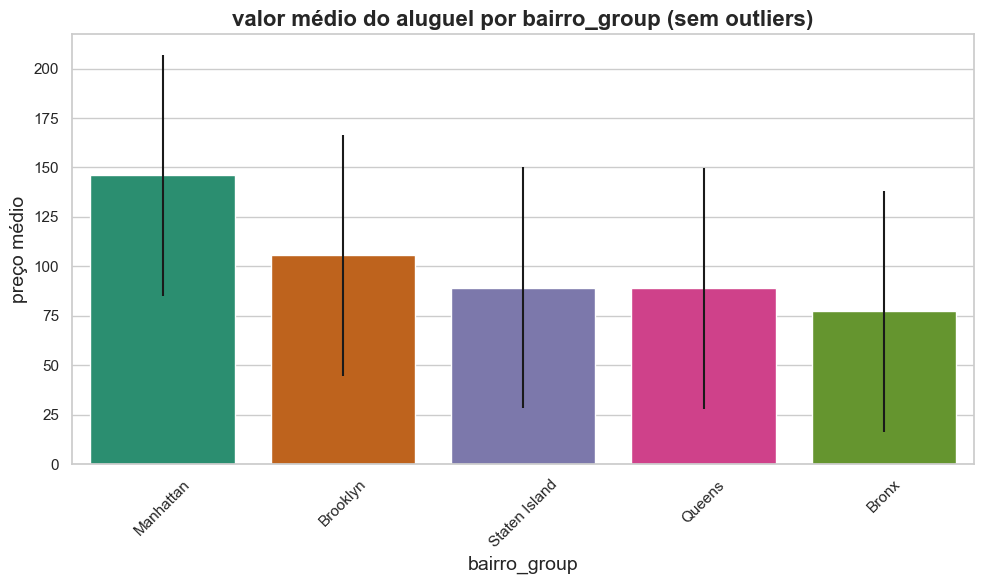

In [45]:
#para calcular a média, desvio padrão, máximo e mínimo de NY
estatisticas_ny         = df1['price'].agg(['mean', 'std', 'min', 'max']).reset_index()
estatisticas_ny.columns = ['metrica', 'valor']

print("\nestatísticas para NY:")
print(estatisticas_ny)

print("--"*25)

#para calcular a média, desvio padrão, máximo e mínimo de cada bairro_group
estatisticas_bairro_group = df1.groupby('bairro_group')['price'].agg(['mean', 'std', 'min', 'max']).reset_index()
estatisticas_bairro_group = estatisticas_bairro_group.sort_values(by = 'mean', ascending = False)
estatisticas_bairro_group = estatisticas_bairro_group.reset_index(drop = True)

print(estatisticas_bairro_group)

sns.set(style = "whitegrid")

#para criar um gráfico de barras
plt.figure(figsize = (10, 6))
sns.barplot(
    x         = 'bairro_group',
    y         = 'mean',
    data      = estatisticas_bairro_group,
    yerr      = estatisticas_bairro_group['std'][1],
    palette   = 'Dark2',
    capsize   = 0.1
)

#para setar o título e o rótulo dos eixos
plt.title('valor médio do aluguel por bairro_group (sem outliers)', fontsize = 16, fontweight = 'bold')
plt.xlabel('bairro_group', fontsize = 14)
plt.ylabel('preço médio',  fontsize = 14)

plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Então na média os bairro_group mais caros são Manhattan e Brooklyn, enquanto os bairros Staten Island e Queens possuem aproximadamente o mesmo preço e o bairro Bronx é o mais barato. 

Conforme analisado, o aluguel em NY possui um valor médio de 119.96$, com um desvio padrão de 68.15$. 

Em relação aos bairro_group, Manhattan é o mais caro, com um aluguel médio de 145.95$ e um desvio padrão de 70.47$.

Calculando os bairro_group mais caros sem os outliers


In [46]:
#procura pelos 10 imóveis mais caros 
top_10_caros = df1.nlargest(10, 'price')[['price', 'bairro_group']]
top_10_caros

price bairro_group
id                          
995367    334.0    Manhattan
30387425  334.0    Manhattan
30387566  334.0    Manhattan
30393759  334.0    Manhattan
33607276  334.0    Manhattan
10403199  333.0     Brooklyn
12093494  333.0    Manhattan
15728780  333.0    Manhattan
20154569  333.0    Manhattan
21919913  333.0    Manhattan

9 dos 10 imóveis mais caros estão no bairro_group Manhattan

Obs: Quanto aos bairro, temos os seguintes valores de locação:

In [47]:
#preço médio por bairro
preco_medio_por_bairro = df1.groupby(['bairro', 'bairro_group'])['price'].max().reset_index()

#os dez bairros mais caros
bairros_caros = preco_medio_por_bairro.sort_values(by = 'price', ascending = False).head(10)
print("Os dez bairros mais caros:")
print(bairros_caros)

bairros_baratos = preco_medio_por_bairro.sort_values(by = 'price', ascending = True).head(10)
print("\nOs dez bairros mais baratos")
print(bairros_baratos)


Os dez bairros mais caros:
                 bairro bairro_group  price
34              Chelsea    Manhattan  334.0
126             Midtown    Manhattan  334.0
91    Greenwich Village    Manhattan  334.0
190    Theater District    Manhattan  334.0
208        West Village    Manhattan  334.0
213        Williamsburg     Brooklyn  333.0
118     Lower East Side    Manhattan  333.0
201     Upper West Side    Manhattan  333.0
196             Tribeca    Manhattan  332.0
73   Financial District    Manhattan  332.0

Os dez bairros mais baratos
                 bairro   bairro_group  price
140            New Dorp  Staten Island   57.0
171           Rossville  Staten Island   75.0
209  Westchester Square          Bronx   75.0
164        Richmondtown  Staten Island   78.0
42           Co-op City          Bronx   80.0
27          Bull's Head  Staten Island   80.0
87           Grant City  Staten Island   80.0
176         Silver Lake  Staten Island   80.0
1         Arden Heights  Staten Island   83.0


Sem os outliers, o valor de aluguel mais caro está em Chelsea e o bairro_group mais caro (Manhattan) possui 9 dos 10 imóveis mais caros por bairro. Quanto aos bairros mais baratos, se destaca o bairro New Dorp em Staten Island.

## Hipóteses de precificação

### Proximidade de pontos turísticos aumenta o valor do imóvel

Em cidades turísticas como Nova York, é esperado que se tenha imóveis mais caros conforme nos aproximamos de pontos turístico. Para essa análise, separei alguns dos principais pontos turísticos para que seja avaliada a variação do valor dos alugueis conforme nos aproximamos deles. Entre os pontos turísticos selecionados estão:

- Central Park 
- Times Square 
- Empire State Building
- Museu da arte moderna
- Museu da cidade de NY 
- Museu memorial
- One World Trade Center
- Centro cívico
- Lincoln Center for the Performing Arts

Obs: a latitude e longitude desses pontos turísticos foi extraída diretamente do Google Maps.

In [48]:
#manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
#
##filtra o bairro_group Manhattan
#mapa_df1 = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn'])]
#
##normaliza os preços dos imóveis entre 0 e 1
#min_price = mapa_df1['price'].min()
#max_price = mapa_df1['price'].max()
#mapa_df1['price_norm'] = (mapa_df1['price'] - min_price) / (max_price - min_price)
#
##seleciona os dados que serão utilizados para plotar o mapa de calor
#mapa_calor_df1 = list(zip(mapa_df1['latitude'], mapa_df1['longitude'], mapa_df1['price_norm']))
#
##plota o mapa de calor
#HeatMap(mapa_calor_df1, 
#        min_opacity = 0.2, 
#        radius      = 10, 
#        blur        = 5, 
#        max_zoom    = 13
#        ).add_to(manhattan_map)
#
##adiciona os principais pontos turísticos 
#pontos_turisticos = [
#    {"nome": "Central Park", "latitude": 40.785091, "longitude": -73.968285},
#    {"nome": "Times Square", "latitude": 40.758896, "longitude": -73.985130},
#    {"nome": "Empire State Building", "latitude": 40.748817, "longitude": -73.985428},
#    {"nome": "Museu da arte moderna", "latitude": 40.763448, "longitude": -73.977157},
#    {"nome": "Museu da cidade de NY", "latitude": 40.79303, "longitude": -73.95476},
#    {"nome": "Museu memorial", "latitude": 40.71227, "longitude": -74.01511},
#    {"nome": "One World Trade Center", "latitude": 40.71249, "longitude": -74.01198},
#    {"nome": "Centro cívico", "latitude": 40.71412, "longitude": -74.00206},
#    {"nome": "Lincoln Center for the Performing Arts", "latitude": 40.77324, "longitude": -73.98667},
#    {"nome": "Brooklyn Bridge", "latitude": 40.70627, "longitude": -73.99676},
#    {"nome": "Brooklyn Bridge Park", "latitude": 40.70240, "longitude": -73.99573},
#    {"nome": "Brooklyn Museum", "latitude": 40.67130, "longitude": -73.96357},
#    {"nome": "McCarren Park", "latitude": 40.72100, "longitude": -73.95159},
#    {"nome": "East River", "latitude": 40.72506, "longitude": -73.96744}
#
#]
#
#for ponto in pontos_turisticos:
#    folium.Marker(
#        location=[ponto['latitude'], ponto['longitude']],
#        popup=ponto['nome'],
#        icon=folium.Icon(color='blue', icon='info-sign')
#    ).add_to(manhattan_map)
#
## Exibe o mapa
#manhattan_map
#

In [49]:
#calculando a distância dos imóveis em relação aos pontos turísticos
pontos_turisticos = [
    {"nome": "Central Park", "latitude": 40.785091, "longitude": -73.968285},
    {"nome": "Times Square", "latitude": 40.758896, "longitude": -73.985130},
    {"nome": "Empire State Building", "latitude": 40.748817, "longitude": -73.985428},
    {"nome": "Museu da arte moderna", "latitude": 40.763448, "longitude": -73.977157},
    {"nome": "Museu da cidade de NY", "latitude": 40.79303, "longitude": -73.95476},
    {"nome": "Museu memorial", "latitude": 40.71227, "longitude": -74.01511},
    {"nome": "One World Trade Center", "latitude": 40.71249, "longitude": -74.01198},
    {"nome": "Centro cívico", "latitude": 40.71412, "longitude": -74.00206},
    {"nome": "Lincoln Center for the Performing Arts", "latitude": 40.77324, "longitude": -73.98667},
    {"nome": "Brooklyn Bridge", "latitude": 40.70627, "longitude": -73.99676},
    {"nome": "Brooklyn Bridge Park", "latitude": 40.70240, "longitude": -73.99573},
    {"nome": "Brooklyn Museum", "latitude": 40.67130, "longitude": -73.96357},
    {"nome": "McCarren Park", "latitude": 40.72100, "longitude": -73.95159},
    {"nome": "East River", "latitude": 40.72506, "longitude": -73.96744}
]

############################################## era df1_filtrado
df1 = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])].copy()

def calcular_distancia_turismo(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers


def calcular_distancia_linha(row, ponto):
    return calcular_distancia_turismo(row['latitude'], row['longitude'], ponto['latitude'], ponto['longitude'])

grupos = {}

for ponto in pontos_turisticos:
    nome_ponto = ponto["nome"]
    df1[f'distancia_{nome_ponto}'] = df1.apply(calcular_distancia_linha, args=(ponto,), axis=1)

df1.to_csv("Airbnb_NY_data+.csv")


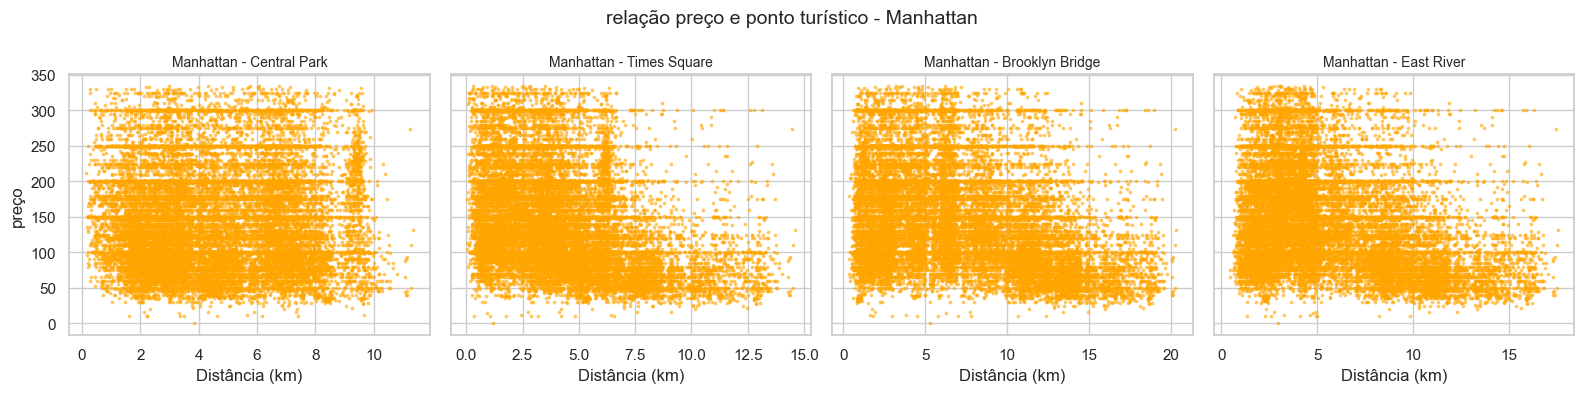

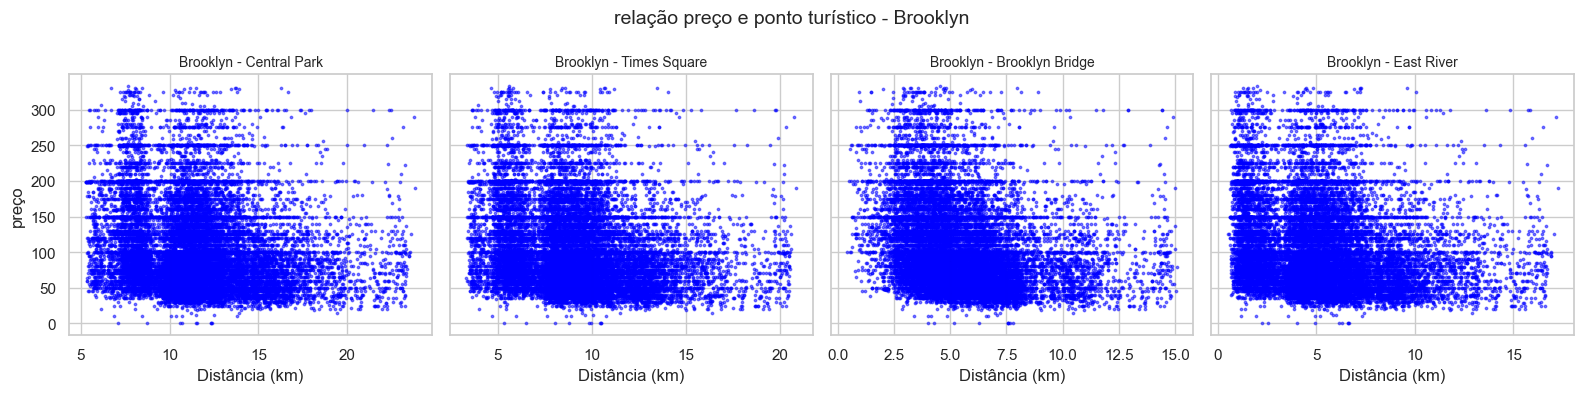

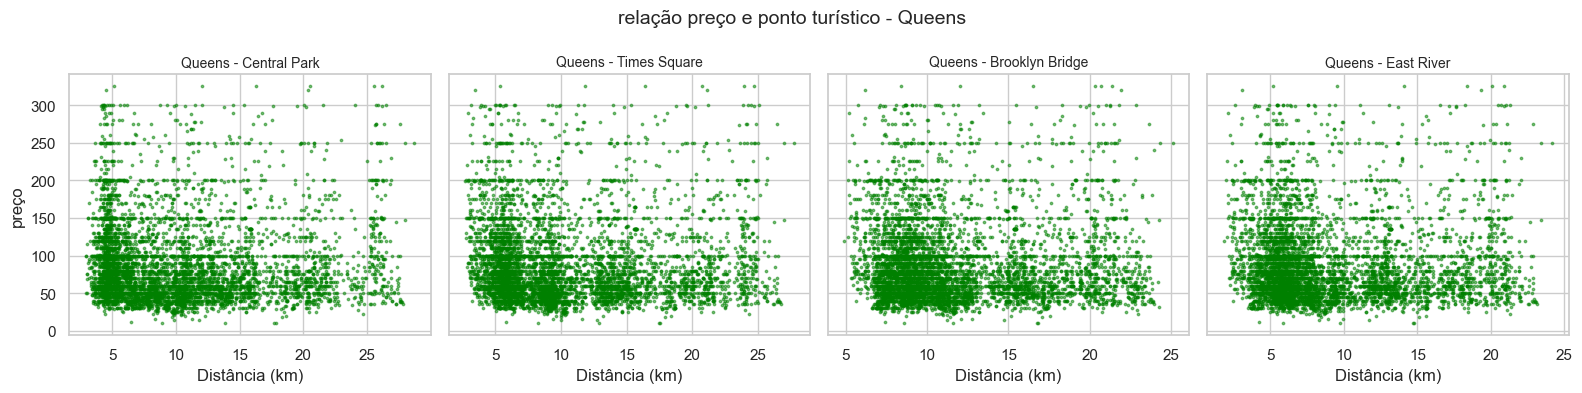

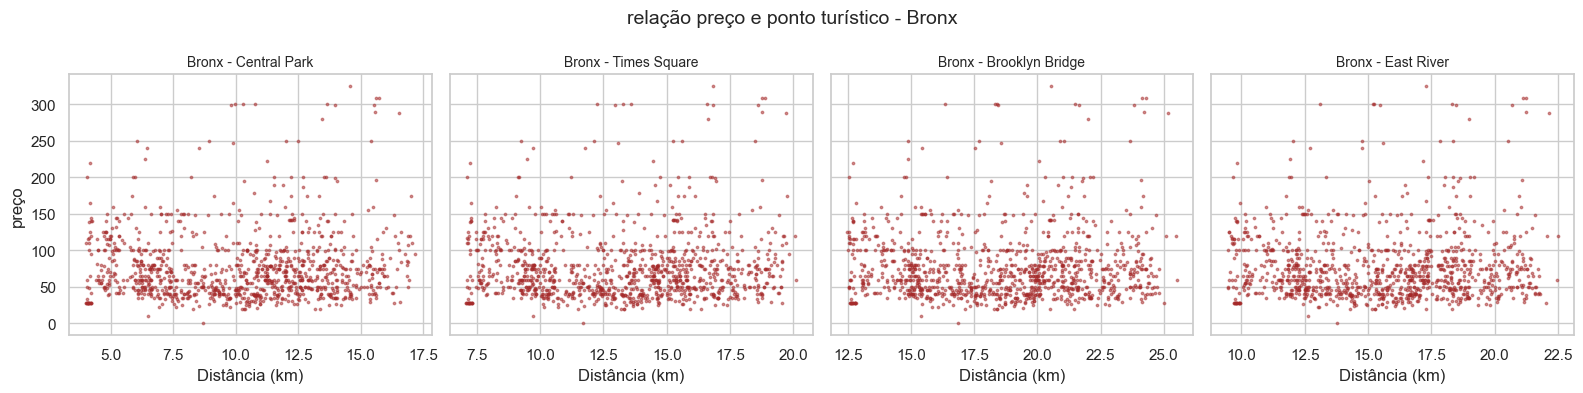

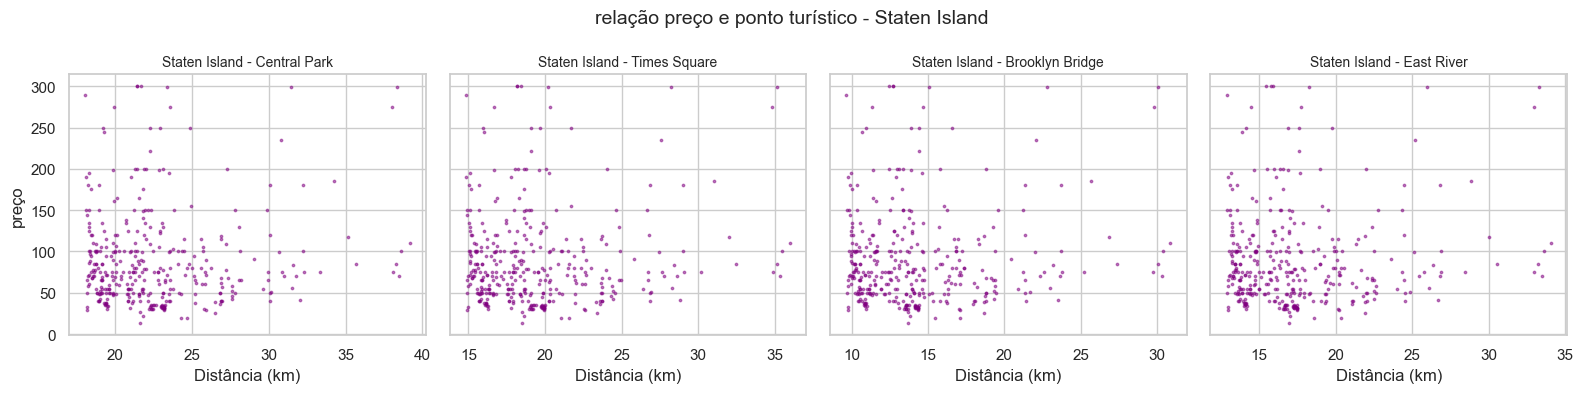

In [50]:
#selecionando os principais pontos turísticos
pontos_selecionados = ["Central Park", "Times Square", "Brooklyn Bridge", "East River"]

#criando um df para cada bairro_group
df_manhattan     = df1[df1['bairro_group'] == 'Manhattan']
df_brooklyn      = df1[df1['bairro_group'] == 'Brooklyn']
df_queens        = df1[df1['bairro_group'] == 'Queens']
df_bronx         = df1[df1['bairro_group'] == 'Bronx']
df_staten_island = df1[df1['bairro_group'] == 'Staten Island']

#lista para acessar os bairro_group individualmente
bairro_group = [
    ('Manhattan', df_manhattan, 'orange'),
    ('Brooklyn', df_brooklyn, 'blue'),
    ('Queens', df_queens, 'green'),
    ('Bronx', df_bronx, 'brown'),
    ('Staten Island', df_staten_island, 'purple')
]

#iterando sobre o bairro_group
for bairro, df, color in bairro_group:
    fig, axes = plt.subplots(1, len(pontos_selecionados), figsize=(16, 4), sharey=True)
    
    for col, nome_ponto in enumerate(pontos_selecionados):
        if f'distancia_{nome_ponto}' in df.columns:
            axes[col].scatter(df[f'distancia_{nome_ponto}'], df['price'], alpha = 0.5, color=color, s = 3)
            axes[col].set_title(f"{bairro} - {nome_ponto}", fontsize=10)
            axes[col].set_xlabel("Distância (km)")
            axes[col].grid(True)
    
    axes[0].set_ylabel("preço") 
    plt.suptitle(f"relação preço e ponto turístico - {bairro}", fontsize = 14)
    plt.tight_layout()
    plt.show()


Conclui-se que não só há maior quantidade de imóveis disponíveis nas proximidades dos pontos turístico como também uma maior presença de imóveis de alto valor

## Proximidade de estações de metrô aumentam o valor do imóvel

Em cidades grandes como NY é necessário uma boa estrutura de mobilidade urbana e a proximidade do imóvel até a estação de metrô pode ser um fator que agregue na precificação do imóvel. Para essa análise, plotaremos um diagrama de calor para o preço dos bairro_group mais caros (Manhattan e Brooklyn) e usaremos como pin as estações de metrô.

In [51]:
#manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
#
##filtra o bairro_group Manhattan
#mapa_df1 = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn'])]
#
##normaliza os preços dos imóveis entre 0 e 1
#min_price = mapa_df1['price'].min()
#max_price = mapa_df1['price'].max()
#mapa_df1['price_norm'] = (mapa_df1['price'] - min_price) / (max_price - min_price)
#
##seleciona os dados que serão utilizados para plotar o mapa de calor
#mapa_calor_df1 = list(zip(mapa_df1['latitude'], mapa_df1['longitude'], mapa_df1['price_norm']))
#
##plota o mapa de calor
#HeatMap(mapa_calor_df1, 
#        min_opacity = 0.2, 
#        radius      = 10, 
#        blur        = 5, 
#        max_zoom    = 13
#        ).add_to(manhattan_map)
#
#for index, row in estacoes.iterrows():
#    folium.CircleMarker(
#        location     = [row['Entrance Latitude'], row['Entrance Longitude']],
#        radius       = 1,                #tamanho do círculo
#        color        = 'blue',           #cor da borda
#        fill         = True,
#        fill_color   = 'blue',           #cor do preenchimento
#        fill_opacity = 0.7,              #opacidade do preenchimento
#        popup        = row['Stop Name']  #texto do pin
#    ).add_to(manhattan_map)
#
#manhattan_map

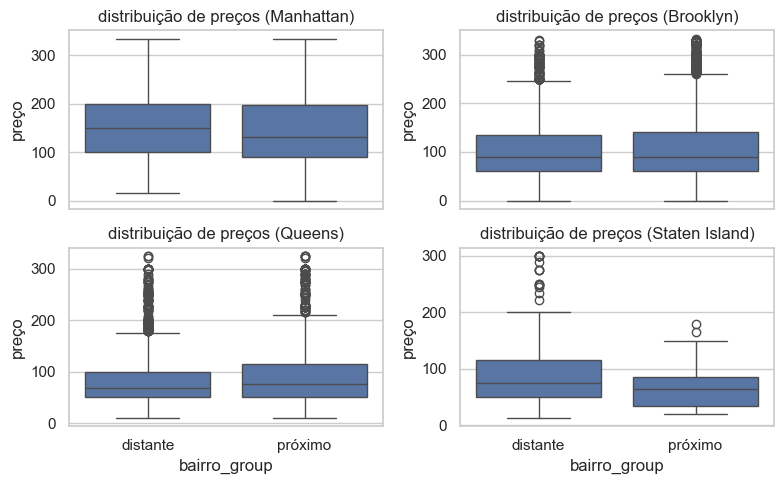

In [52]:
#para acessar os bairro_group
bairros     = df1['bairro_group'].unique()
num_bairros = min(len(bairros), 4)

#para criar o subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (8, 5), sharex=True)
axes      = axes.flatten()

#iterando sobre os bairros
for i in range(num_bairros):

    bairro     = bairros[i]
    df2_bairro = df1[df1['bairro_group'] == bairro] 
    
    #cria um boxplot para os imóveis a menos de 500 metros do metrô
    sns.boxplot(x=df2_bairro['distancia_metro'] <= 500.0, y=df2_bairro['price'], ax=axes[i])
    
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['distante', 'próximo'])
    axes[i].set_title(f'distribuição de preços ({bairro})')
    axes[i].set_xlabel('bairro_group')
    axes[i].set_ylabel('preço')

plt.tight_layout()
plt.show()


Não existe correlação entre a proximidade do imóvel com as estações de metrô e o aumento do seu valor, muito provavelmente pelo fato das estações de metrô estarem bem distribuídas ao longo dos bairro_group.

## Proximidade de pontos de ônibus aumentam o valor do imóvel

In [53]:
#manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12)
#
##filtra o bairro_group Manhattan
#mapa_df1 = df1[df1['bairro_group'].isin(['Manhattan', 'Brooklyn'])]
#
##normaliza os preços dos imóveis entre 0 e 1
#min_price = mapa_df1['price'].min()
#max_price = mapa_df1['price'].max()
#mapa_df1['price_norm'] = (mapa_df1['price'] - min_price) / (max_price - min_price)
#
##seleciona os dados que serão utilizados para plotar o mapa de calor
#mapa_calor_df1 = list(zip(mapa_df1['latitude'], mapa_df1['longitude'], mapa_df1['price_norm']))
#
##plota o mapa de calor
#HeatMap(mapa_calor_df1, 
#        min_opacity = 0.2, 
#        radius      = 10, 
#        blur        = 5, 
#        max_zoom    = 13
#        ).add_to(manhattan_map)
#
#for index, row in ponto_onibus.iterrows():
#    folium.CircleMarker(
#        location     = [row['Latitude'], row['Longitude']],
#        radius       = 1,       #tamanho do círculo
#        color        = 'blue',  #cor da borda
#        fill         = True,
#        fill_color   = 'blue',  #cor do preenchimento
#        fill_opacity = 0.7,     #opacidade do preenchimento
#    ).add_to(manhattan_map)
#
#manhattan_map

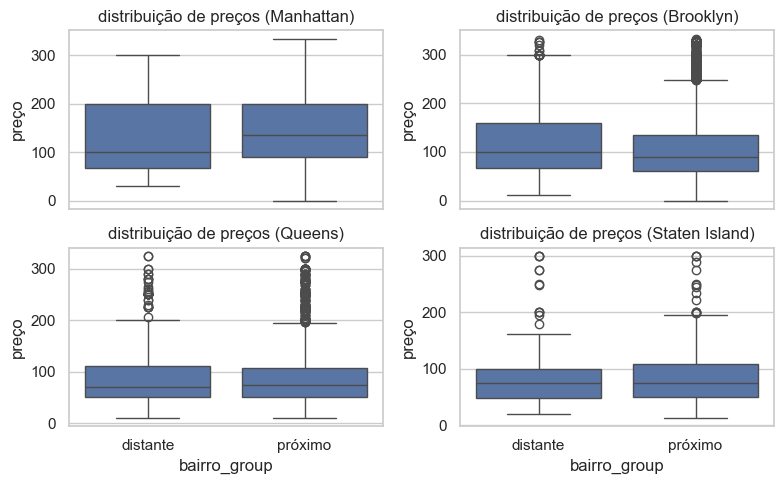

In [54]:
#para acessar os bairro_group
bairros = df1['bairro_group'].unique()

#para criar o subplot
num_bairros = min(len(bairros), 4)

#iterando sobre os bairros
fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (8, 5), sharex=True)
axes      = axes.flatten()

for i in range(num_bairros):
    
    bairro     = bairros[i]
    df2_bairro = df1[df1['bairro_group'] == bairro]  

    #cria um boxplot para os imóveis a menos de 500 metros do ponto de ônibus
    sns.boxplot(x=df2_bairro['distancia_onibus'] <= 500.0, y=df2_bairro['price'], ax=axes[i])
    
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['distante', 'próximo'])
    axes[i].set_title(f'distribuição de preços ({bairro})')
    axes[i].set_xlabel('bairro_group')
    axes[i].set_ylabel('preço')

plt.tight_layout()
plt.show()

## Bairros mais seguros devem ser mais caros 

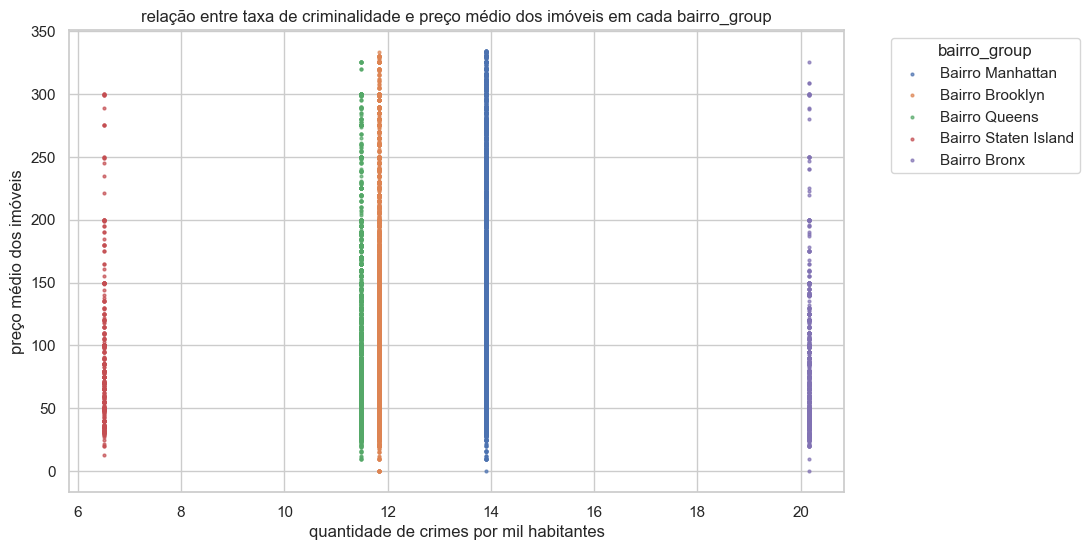

In [55]:
df1 = pd.DataFrame(df1)

#plotando um gráfico de dispersão para cada bairro_group
plt.figure(figsize=(10, 6))

#itera sobre o bairro_group
for bairro in df1['bairro_group'].unique():

    subset = df1[df1['bairro_group'] == bairro]
    plt.scatter(subset['taxa_de_crimes'], subset['price'], label=f'Bairro {bairro}', alpha=0.7, s = 4)

#adiciona o título e os rótulos do label
plt.title('relação entre taxa de criminalidade e preço médio dos imóveis em cada bairro_group')
plt.xlabel('quantidade de crimes por mil habitantes')
plt.ylabel('preço médio dos imóveis')
plt.legend(title='bairro_group', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.grid(True)
plt.show()

## O room_type influência no preço do imóvel 

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\1755788311.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=df1, palette='Dark2')


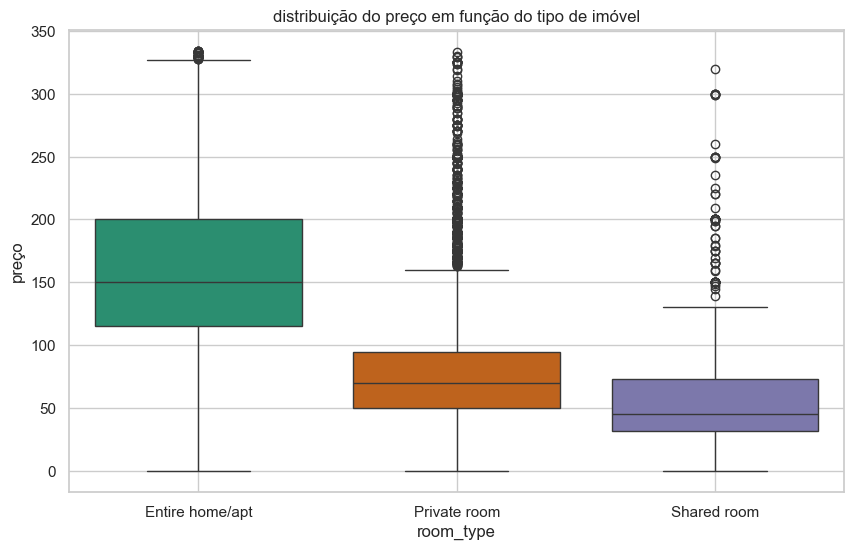

In [56]:
df1 = pd.DataFrame(df1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df1, palette='Dark2')
plt.title('distribuição do preço em função do tipo de imóvel')
plt.xlabel('room_type')
plt.ylabel('preço')
plt.grid(True)
plt.show()


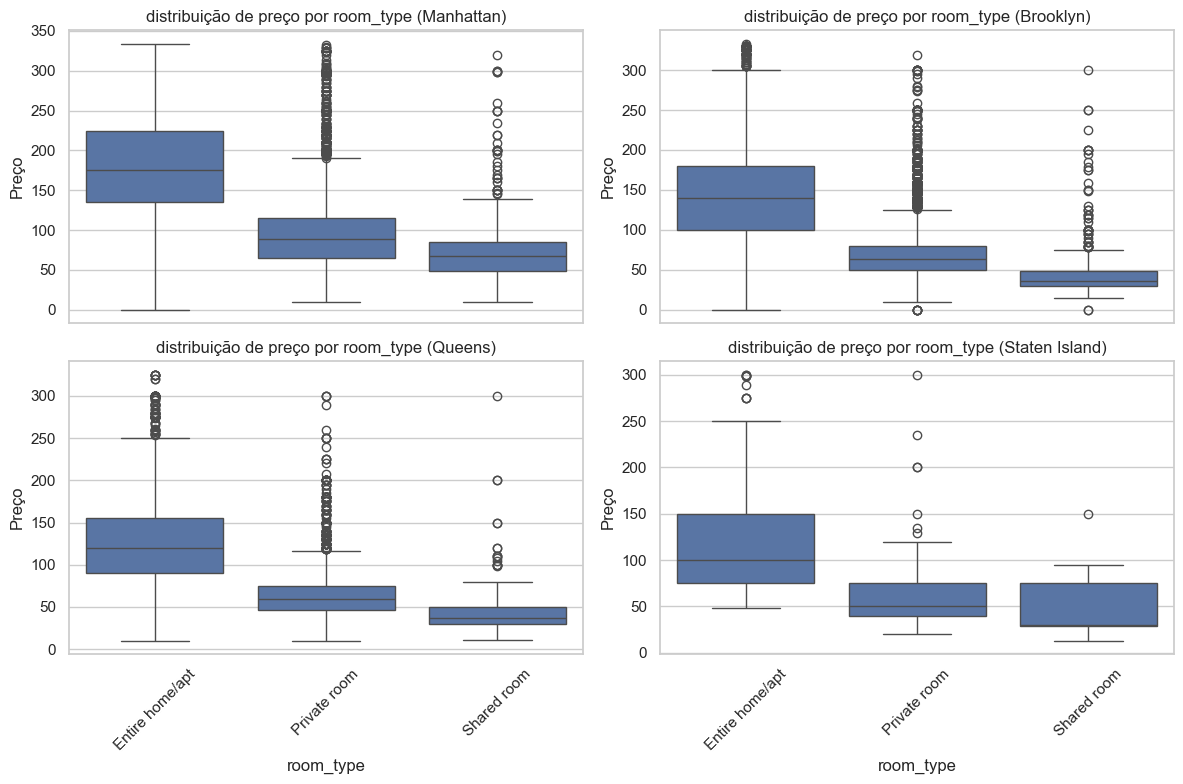

In [57]:

bairros = df1['bairro_group'].unique()

#para acessar os bairro_group
num_bairros = min(len(bairros), 4)  

#para criar o subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

#itera sobre os bairros
for i in range(num_bairros):
    
    bairro = bairros[i]
    df_bairro = df1[df1['bairro_group'] == bairro]  

    #cria um boxplot para os bairro_group mostrando os room_type
    sns.boxplot(x=df_bairro['room_type'], y=df_bairro['price'], ax=axes[i])
    
    axes[i].set_title(f'distribuição de preço por room_type ({bairro})')
    axes[i].set_xlabel('room_type')
    axes[i].set_ylabel('Preço')

    #rotaciona o rótulo
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\2384779260.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quartos', y='price', data=df1, palette='Dark2')


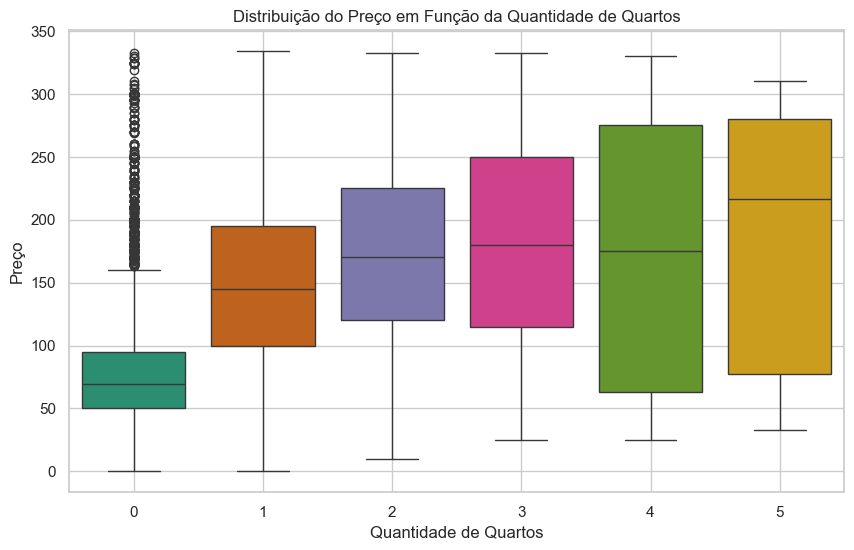

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='quartos', y='price', data=df1, palette='Dark2')
plt.title('Distribuição do Preço em Função da Quantidade de Quartos')
plt.xlabel('Quantidade de Quartos')
plt.ylabel('Preço')
plt.grid(True)
plt.show()

## Conclusões retiradas da EDA e das hipóteses:

- Manhattan é o 'bairro_group' com a maior quantidade de imóveis
- Brooklyn possui o 'bairro' com maior número de imóveis (Williamsburg).
- Manhattan é o único bairro que possui como maior 'room_type' 'Entire home/apt'
- O preço médio dos 'Entire home/ap't é maior em todos os 'bairro_group'
- O bairro com a maior quantidade média de quartos é Manhattan
- Em Manhattan e no Brooklyn a quantidade de quartos aumenta conforme nos aproximamos de pontos turísticos
- Brooklyn é o 'bairro_group' com maior número de reviews
- O número de reviews é maior em preços mais baixos, então talvez as pessoas dêem mais reviews quando estão insatisfeitas
- O número de reviews é maior nos meses 6 e 7, época onde a estação do ano é verão em NY. Isso condiz com a realidade das pesquisas: NY possui mais visitas no verão
- O maior valor médio de aluguel é em Manhattan (145.95 +/- 70.8) e o segundo em Brooklyn (105.69 +/- 60.93)
- Manhatan possui 9 dos 10 bairros com maior preço médio
- O bairro mais caro é Chelsea (Manhattan) e o mais barato New Drop (Staten Island)
- Conforme no aproximamos de pontos turísticos, há uma maior concetração tanto de imóveis quanto de preços mais altos em Manhattan, Brooklyn e no Queens
- A proximidade de estações de metrô influencia pouco o preço dos imóveis, muito provavelmente pelo fato da cidade ter as estações de metrô muito bem distribuídas, o mesmo vale para os ônibus
- O bairro mais seguro e barato é Staten Island, porém é mais isolado
- Bronx possui preços menore mas uma alta taxa de crimes / 1000 habitantes
- A quantidade de quartos influencia no preço, quanto maior o número de quartos maior o preço
- O 'room_type' infleuncia no preço do imóvel e, em todos os 'bairro_group' o mais caro é o 'Entire home/apt', seguidos de 'Private room' e 'Shared room' 
- Existem residências que provavelmente são consideradas de 'luxo' e possuem o valor tão elevado que foi necessário serem retiradas do espaço amostral

# Questão 2 

Respostas: 

## a) 

Para responder a essa pergunta, é interessante observar se existem hosts que possuem mais de um imóvel e, se sim, em qual bairro esse imóvel se encontra. Além disso, é importante levar em consideração as análises exploratórias realizadas na "Questão 1" e as suas conclusões.

Primeiro: existem hosts com mais de um imóvel?

In [59]:
df1 = pd.read_csv("Airbnb_NY_data+.csv")

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\1699171198.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("Airbnb_NY_data+.csv")


In [60]:
#agrupando por host_id que se repete para calcular a quantiade de imóveis 
imoveis_por_host = df1.groupby('host_id')['id'].count().reset_index(name = 'total_imoveis')

imoveis_por_host = imoveis_por_host.sort_values(by = 'total_imoveis', ascending = False)

imoveis_por_host.head(4)

host_id  total_imoveis
32899  219517861            272
27974  107434423            180
29565  137358866            103
18585   30283594             95

Vamos analisar se os host_id diversificam o bairro_group de investimento:

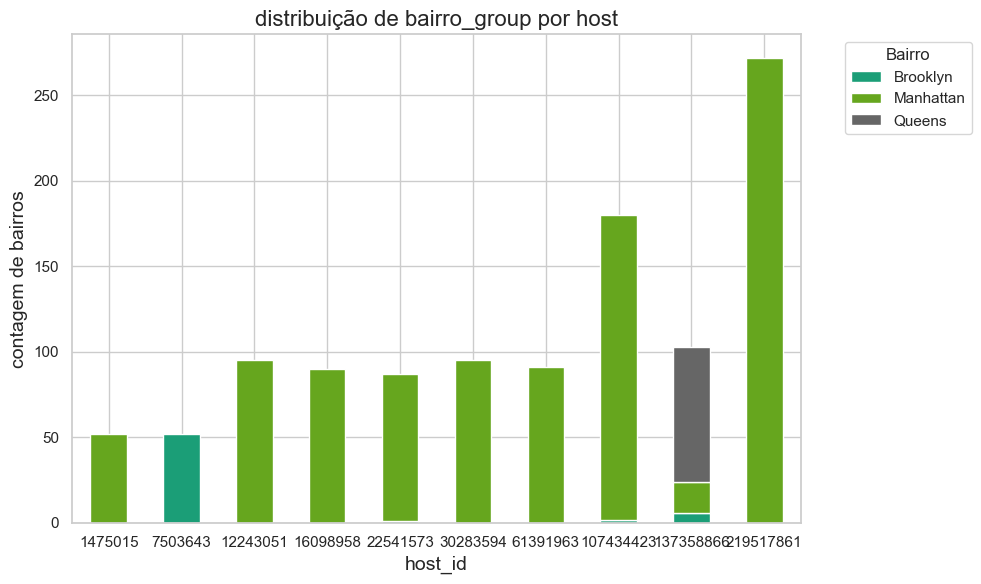

In [61]:
#filtrando os top 5 maiores hosts
lista    = df1["host_id"].value_counts().head(10).sort_values(ascending=False)
host_ids = lista.index  

#filtrar o df1 para os host_ids
host_filtrado = df1[df1['host_id'].isin(host_ids)]

#agrupar os bairros para cada host_id
bairro_group_host = host_filtrado.groupby(['host_id', 'bairro_group']).size().unstack(fill_value=0)

#gerar o gráfico
bairro_group_host.plot(kind = 'bar', stacked = True, figsize = (10, 6), colormap = 'Dark2')

#inserir título e rótulo aos eixos
plt.title('distribuição de bairro_group por host', fontsize = 16)
plt.xlabel('host_id', fontsize = 14)
plt.ylabel('contagem de bairros', fontsize = 14)
plt.xticks(rotation = 0) 
plt.legend(title = 'Bairro', bbox_to_anchor = (1.05, 1), loc = 'upper left')  

plt.tight_layout()
plt.show()

Eles não diversificam muito o investimento e tem o foco principal em Manhattan, mas em qual bairro?

In [62]:
#conta quantos imóveis estão disponíveis por bairro
imoveis_disponiveis = df1_filtrado.groupby(['bairro', 'bairro_group']).size().reset_index(name='imoveis_disponiveis')

#contamos quantos hosts tem no bairro, depois filtramos para saber quantos hosts tem mais de um imóvel e por fim, calculamos a quantidade total de hosts com mais de um imóvel
contagem_hosts = df1_filtrado.groupby(['bairro', 'bairro_group', 'host_id']).size().reset_index(name='contagem')
hosts_repetidos = contagem_hosts[(contagem_hosts['contagem'] >= 1) & (contagem_hosts['contagem'] <= 4)]
bairros_mais_repetidos = hosts_repetidos.groupby(['bairro', 'bairro_group'])['host_id'].nunique().reset_index(name='hosts_repetidos')

#calcula o preço médio e desvio padrão do bairro
preco_stats_bairro = df1_filtrado.groupby('bairro')['price'].agg(
    preco_medio_bairro  = ('mean'), 
    desvio_padrao_bairro= ('std')
).reset_index()

#calcula o preço médio e desvio padrão do bairro_group
preco_stats_bairro_group = df1_filtrado.groupby('bairro_group')['price'].agg(
    preco_medio_bairro_group   = ('mean'), 
    desvio_padrao_bairro_group = ('std')
).reset_index()

#calcula a média de reviews por mês no bairro
reviews_por_mes = df1_filtrado.groupby('bairro')['reviews_por_mes'].mean().reset_index(name='reviews_por_mes')

#mescla os dados no dataframe principal
bairros_mais_repetidos = bairros_mais_repetidos.merge(imoveis_disponiveis, on=['bairro', 'bairro_group'], how='left')
bairros_mais_repetidos = bairros_mais_repetidos.merge(preco_stats_bairro, on='bairro', how='left')
bairros_mais_repetidos = bairros_mais_repetidos.merge(preco_stats_bairro_group, on='bairro_group', how='left')
bairros_mais_repetidos = bairros_mais_repetidos.merge(reviews_por_mes, on='bairro', how='left')

#ordena e seleciona os 10 primeiros bairros
top_10_bairros = bairros_mais_repetidos.sort_values(by='hosts_repetidos', ascending = False).head(10)

top_10_bairros

bairro bairro_group  hosts_repetidos  imoveis_disponiveis  \
214        Williamsburg     Brooklyn             3353                 3911   
13   Bedford-Stuyvesant     Brooklyn             2731                 3704   
94               Harlem    Manhattan             2096                 2653   
28             Bushwick     Brooklyn             1862                 2464   
64         East Village    Manhattan             1603                 1841   
202     Upper West Side    Manhattan             1547                 1948   
201     Upper East Side    Manhattan             1370                 1785   
95       Hell's Kitchen    Manhattan             1318                 1951   
51        Crown Heights     Brooklyn             1288                 1561   
127             Midtown    Manhattan              938                 1526   

     preco_medio_bairro  desvio_padrao_bairro  preco_medio_bairro_group  \
214          139.783176            100.798668                117.806374   
13           101.385529             80.259314                117.806374   
94           114.034301             90.646101                178.936293   
28            84.023133             64.653572                117.806374   
64           173.775122            109.831286                178.936293   
202          177.995380            130.420794                178.936293   
201          172.235294            112.753315                178.936293   
95           196.944131            129.622550                178.936293   
51           108.788597             87.021322                117.806374   
127          265.693316            179.509727                178.936293   

     desvio_padrao_bairro_group  reviews_por_mes  
214                   94.408160         0.888642  
13                    94.408160         1.314587  
94                   133.893998         1.113581  
28                    94.408160         1.068324  
64                   133.893998         0.905524  
202                  133.893998         0.761396  
201                  133.893998         0.850605  
95                   133.893998         1.444557  
51                    94.408160         0.999283  
127                  133.893998         0.823585

### Conclusão

Em conclusão, acredito que o bairro mais indicado para comprar um imóvel seja Williamsburg. Este bairro possui uma grande disponibilidade de imóveis disponíveis para locação e um preço médio de 124.20$, com desvio padrão de 66.90$. Além disso, o bairro fica próximo dos principais pontos turístico, o que é algo favorável caso o proprietário pretenda alugar o seu imóvel com uma quantidade mínima de noites menor.

### b)

Acredito que o número mínimo de noites esteja intimamente ligado ao preço. Imóveis com uma quantidade de noites mínimas menor são mais destinados a turistas que ficam na cidade entr 7 e 30 dias. Enquanto isso, imóveis com um número mínimo de noites maior normalmente são destinados a pessoas locais ou para quem está viajando a trabalho. Para ver se essa relação é verdadeira:


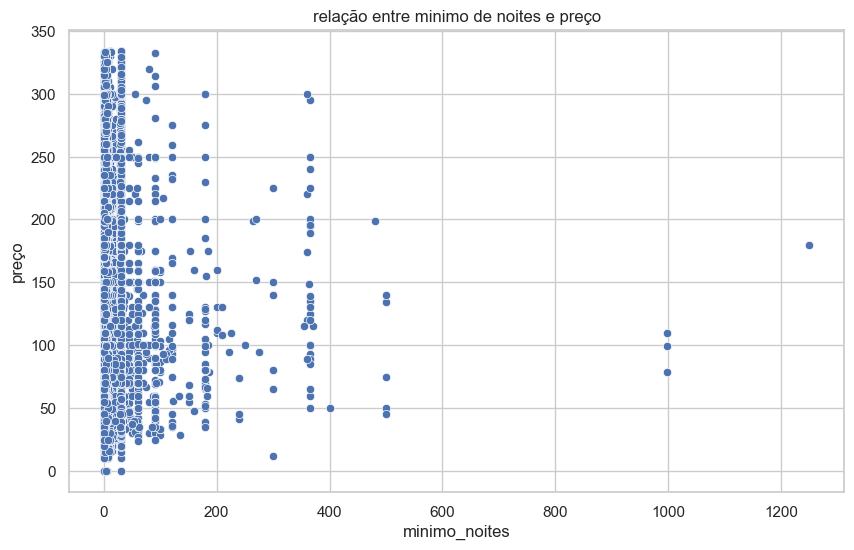

In [63]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = df1, x = 'minimo_noites', y = 'price')
plt.xlabel('minimo_noites')
plt.ylabel('preço')
plt.title('relação entre minimo de noites e preço') 
plt.show()

Vamos calcular o preço médio dos alugueis para cada bairro_group em função do minimo_noites:

In [64]:
df_filtrado = df1[df1['minimo_noites'] < 10]

#calcula o preço médio por 'bairro_group'
tabela_media = df_filtrado.groupby('bairro_group').agg({
    'price': 'mean',
    'minimo_noites': 'mean'
}).reset_index()

tabela_media

bairro_group       price  minimo_noites
0          Bronx   78.142999       2.225422
1       Brooklyn  107.170546       2.700374
2      Manhattan  144.095350       2.647264
3         Queens   91.136163       2.232679
4  Staten Island   89.302941       2.282353

In [65]:
df_filtrado = df1[df1['minimo_noites'] > 10]

#calcula o preço médio por bairro_group
tabela_media = df_filtrado.groupby('bairro_group').agg({
    'price': 'mean',
    'minimo_noites': 'mean'
}).reset_index()

tabela_media

bairro_group       price  minimo_noites
0          Bronx   65.516667      44.150000
1       Brooklyn   94.398077      32.871635
2      Manhattan  155.166524      35.033590
3         Queens   68.365314      30.955720
4  Staten Island   84.571429      45.000000

Imóveis com uma maior disponibilidade de dias provavelmente tem uma rotativa maior de pessoas e, devido a isso, provavelmente tem um valor menor. Para verificar isso:

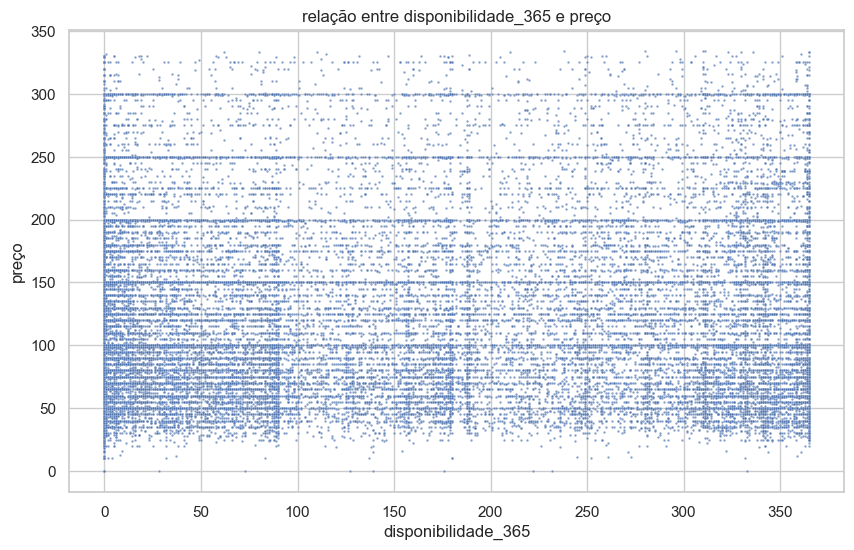

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x='disponibilidade_365', y='price', alpha=0.7, s = 3)
plt.xlabel('disponibilidade_365')
plt.ylabel('preço')
plt.title('relação entre disponibilidade_365 e preço') 
plt.show()

Existe uma distribuição muito parecida entre a disponibilidade_365 e o preço, parecendo não haver relação.

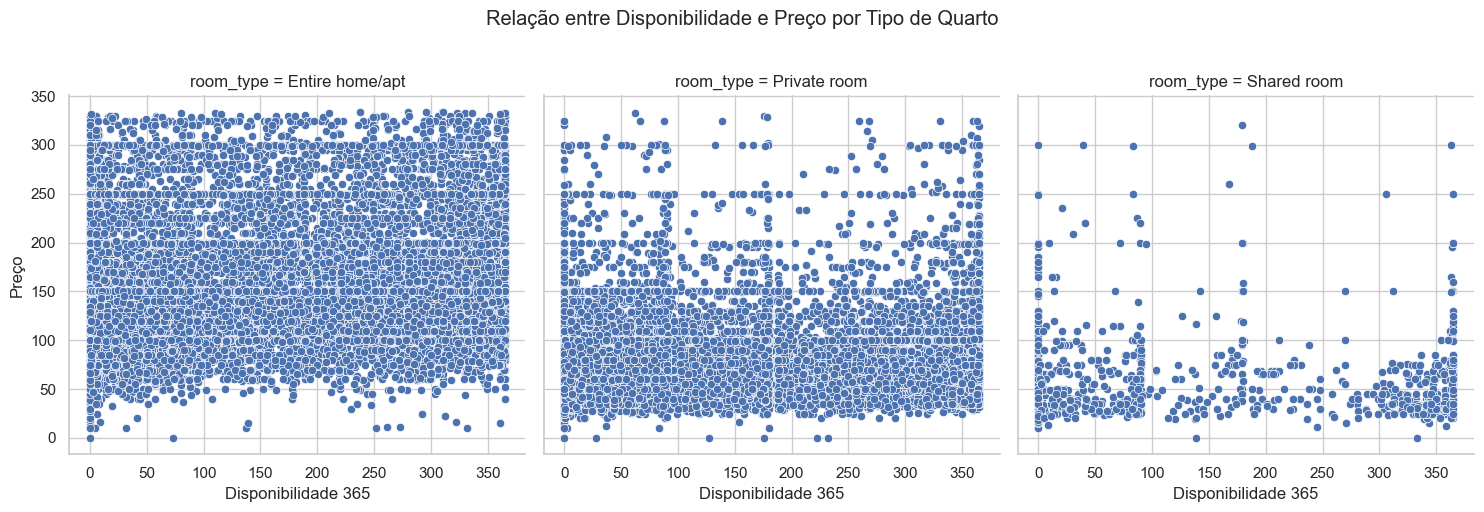

In [67]:
g = sns.FacetGrid(df1, col = 'room_type', col_wrap = 3, height = 5)  
g.map(sns.scatterplot, 'disponibilidade_365', 'price')  

#para adicionar o titulo e rótulo aos eixos
g.set_axis_labels('Disponibilidade 365', 'Preço')
g.fig.suptitle('Relação entre Disponibilidade e Preço por Tipo de Quarto', y=1.02)

plt.tight_layout()
plt.show()

Imóveis do tipo 'Entire home/apt possuem um valor mais alto mas isso não é muito correlacionado a quantidade de dias disponíveis pois são por si só imóveis de mais alto valor.

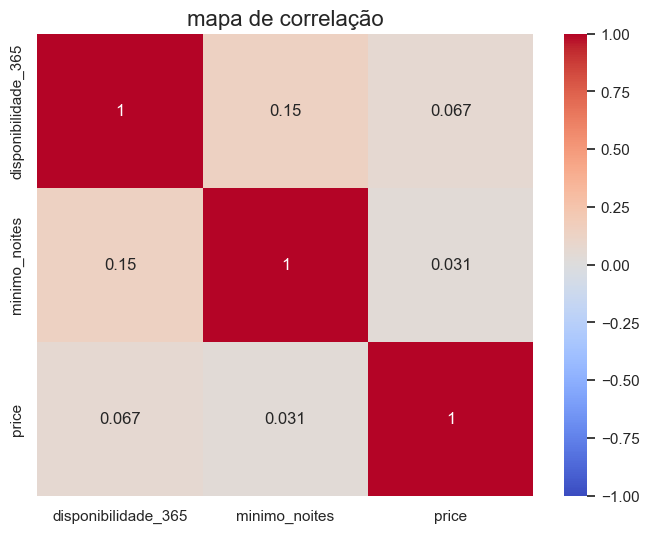

In [68]:
correlacao = df1[['disponibilidade_365', 'minimo_noites', 'price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('mapa de correlação', fontsize=16)
plt.show()

### c)

Acredito que haja um padrão nos nomes dos anúncios para imóveis de alto valor. Pela inspeção visual, é possível notar que certas palavras são frequentemente usadas para destacar o bairro_group do imóvel, a quantidade de quartos e até mesmo o tamanho do apartamento. Como esses fatores influenciam significativamente o preço final, vamos identificar as palavras mais recorrentes nos anúncios de imóveis cujo preço está no maior quartil (> 75%).

Para isso, é necessário se assegurar que a coluna 'nome' esteja limpa o suficiente para fazer a análise:

In [69]:
df_nome = df1.copy()

In [70]:
#removendo caracteres especiais, pontuação e pontuação desnecessária
def remover_desnecessario(line):
    return re.sub('[^A-Za-z]+', ' ', line).lower()

df_nome['nome_limpo'] = df_nome['nome'].apply(remover_desnecessario)

df_nome[['nome', 'nome_limpo']].head()


nome  \
0                             Skylit Midtown Castle   
1               THE VILLAGE OF HARLEM....NEW YORK !   
2                   Cozy Entire Floor of Brownstone   
3  Entire Apt: Spacious Studio/Loft by central park   
4         Large Cozy 1 BR Apartment In Midtown East   

                                        nome_limpo  
0                            skylit midtown castle  
1                  the village of harlem new york   
2                  cozy entire floor of brownstone  
3  entire apt spacious studio loft by central park  
4          large cozy br apartment in midtown east

Agora, utilizaremos a biblioteca stopwords para filtrar palavras comuns e conectivos que não agreguem na análise, além disso, vamos tirar manualmente mais algumas palavras que, por inspeção, aparecem frequentemente.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\2753075870.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['words'] = df_filtrado['nome'].apply(pre_processamento)
C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\2753075870.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.drop(columns=['words'], inplace=True)


         palavra  frequencia  preco_medio
0           east        1018   214.389980
1        village        1008   220.337302
2       spacious         913   218.785323
3           park         814   217.448403
4   williamsburg         713   216.218794
5      manhattan         709   217.265162
6         luxury         705   225.339007
7           west         690   220.897101
8           cozy         687   208.641921
9       brooklyn         652   210.527607
10          loft         644   225.892857
11         heart         611   218.726678
12        modern         588   218.540816
13     beautiful         586   217.244027
14           nyc         536   221.095149
15       central         530   221.064151
16         sunny         515   208.858252
17       midtown         507   221.201183
18          near         468   221.504274
19        bright         454   216.110132
20         large         442   221.235294
21      location         421   214.418052
22          home         419   222

(-0.5, 799.5, 399.5, -0.5)

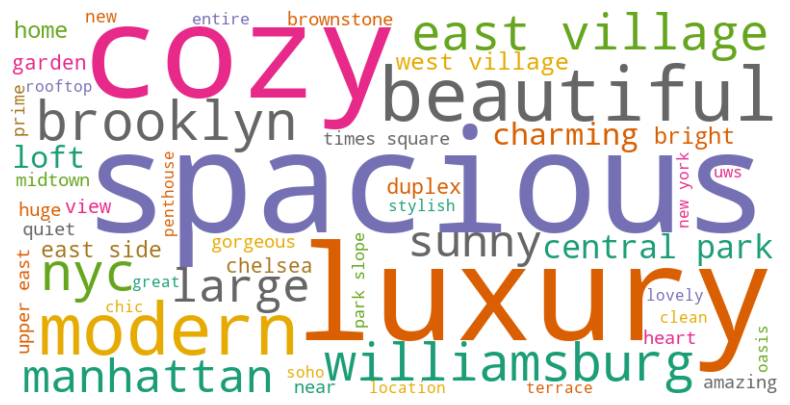

In [71]:
#baixa as stopwords que serão retiradas 
nltk.download('stopwords')

df_nome = pd.DataFrame(df1)

#algumas stopwords que podem atrapalhar vão ser retiradas manualmente 
palavras_irrelevantes = {'apartment', 'bedroom', 'bedr', 'room', 'apt', 'bed', 'br', 
                         '1br', '2br', 'private', 'studio', 'bathroom', 'bath', 'two', 
                         'w', 'one', '1', '2', '3', '6', '10', '45', '21', '12', '7' '8', 
                         '★', '❤️', '❤', '✰', '2b', '•', '✪', '⭐', '9', '☀', '♛', '♥', 
                         '★★', '★★★★★', '❤️'}

#pre processamento do texto
def pre_processamento(text):

    #remove as pontuações
    text = text.translate(str.maketrans('', '', string.punctuation))

    #converte para letas minúsculas
    text = text.lower()

    #remove as stopwords
    stop_words = set(stopwords.words('english')).union(palavras_irrelevantes )
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

#calcula o quartil superior para selecionar os maiores preços
quartil_75 = df_nome['price'].quantile(0.75)

#filtra os itens que possuem 'price' no quartil superior 
df_filtrado = df_nome[df_nome['price'] > quartil_75]

#aplica a função de pre processamento em cada linha
df_filtrado['words'] = df_filtrado['nome'].apply(pre_processamento)
df_extraido = df_filtrado.explode('words')

#remove a coluna temporária do df_nome para salvar memória
df_filtrado.drop(columns=['words'], inplace=True)

#conta a frequência de palavras
word_counts = df_extraido['words'].value_counts().reset_index()
word_counts.columns = ['palavra', 'frequencia']

#calcula o preço médio associado a cada palavra, extraindo o preço do imóvel em que elas apareceram e calculando a média 
price_medio =df_extraido.groupby('words')['price'].mean().reset_index()
price_medio.columns = ['palavra', 'preco_medio']

#juna as informações de preço e frequência 
df_word_counts = pd.merge(word_counts, price_medio, on = 'palavra', how = 'left')

#ordena pelo 'preco_medio' a que cda uma está associada 
df_word_counts = df_word_counts.sort_values(by = 'frequencia', ascending=False)

#salva as palavras mais frequentes no arquivo 'palavras_frequentes.csv'
df_word_counts.to_csv('palavras_frequentes.csv', index = False)

#exibe as dez palavras mais frequentes e o seu preço médio associado 
print(df_word_counts.head(25))

#cria uma string com toda a nuvem de palavra
texto_nuvem_palavra = ' '.join([word for word in df_extraido['words'] if isinstance(word, str)])

#gera a nuvem de palavra
wordcloud = WordCloud(
    width            = 800,               
    height           = 400,            
    background_color = 'white',  
    max_words        = 50,           
    colormap         = 'Dark2'      
).generate(texto_nuvem_palavra)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off') 


# Questão 3

# Machine Learning 

Em problemas de regressão o modelo tenta prever um valor numérico com base nas variáveis de entrada. Logo, estamos enfrentando um problema de regressão, onde nosso objetivo é prever o valor da variável 'price', avaliando diversas outras variáveis. Para isso, vamos realizar as seguintes etapas:

1. Pré-processamento de dados:
- Verificar valores faltantes (NaN) e decidir como tratá-los;
- Codificar variáveis categóricas (nome, bairro, room_type); para a variável 'nome' usaremos a técnica ___ enquanto para o bairro usaremos substituição direta, pois eles possuem uma ordem de preço bem estabelecida. Para o room_type também temos uma ordem de preço bem estabelecida então faremos substituição direta;
- Normalizar ou padronizar as variáveis numéricas;
2. Divisão do dataframe em treino e teste (será utilizado 80% treino e 20% teste);
3. Teste de modelos

Estamos enfrentando um problema de regressão, uma vez que o objetivo do nosso modelo será PREVER um valor numérico com base nas variáveis de entrada. O nosso objetivo será prever o valor da variável 'price', usando como base diversas outras variáveis. Para isso, vamos realizar as segintes etapas

1. Pré-processamento de dados:
- Algumas manipulações já foram feitas, como retirar NaN, acertar o tipo de cada variável e excluir os outliers. Ainda precisamos transformar variáveis categóricas como 'bairro_group', 'bairro' e 'room_type' em variáveis numéricas. Isso será feito baseando-se no estudo que foi realizado nas Questões 1 e 2.
2. Dividir o nosso dataframe  em treino e teste para aperfeiçoamento do modelo
3. Seleção das features (variáveis que usaremos para prever o preço) => isso também será feito com base no que foi estudado e também usaremos uma tabela de correlação para nos guiar 
4. Teste de modelos: testaremos os modelos XGBRegressor, Ridge, RandomForestRegressor, LinearRegression, LGBMRegressor, CatBoostRegressor que são bons modelos para serem usados em problemas de regressão.

### Lista de prós e contras de cada modelo:

- XGBRegressor: alta precisão e velocidade porém muito sensível aos seus hiperparâmetros (que são inúmeros)

fontes: 

https://www.datacamp.com/tutorial/xgboost-in-python

https://www.kaggle.com/code/kenji19840210/basic-prediction-with-xgboost-xgbregressor

https://machinelearningmastery.com/xgboost-for-regression/

- Ridge Regression: é eficiente em problemas lineares mas a relação entre o preço e as demais variáveis não é linear, então pode apresentar um desempenho ruim

fontes:

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

https://medium.com/@msoczi/ridge-regression-step-by-step-introduction-with-example-0d22dddb7d54


- RandomForestRegressor: assim como o XGBRegressor possui alta precisão, porém é mais lento e tende a sofrer overfitting em dados muito turbulentos

https://www.geeksforgeeks.org/random-forest-regression-in-python/

https://www.datacamp.com/tutorial/random-forests-classifier-python


- Linear Regression: mesmo problema do Ridge Regression, este modelo assume que a relação entre o 'price' e as demais variáveis é algo linear

https://www.geeksforgeeks.org/linear-regression-python-implementation/


- CatBoostRegressor: possui uma boa precisão porém é lento.

https://www.datacamp.com/tutorial/catboost

https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview


Obs: O CatBoostRegressor possui uma boa precisão, assim como o XGBRegressor porém é menos flexível em relação aos seus hiperparâmentros o que para pessoas que ainda estão estudando para entender melhor esses modelos, é algo positivo


### Como decidir qual modelo é melhor?

Para decidir qual modelo é melhor usaremos três parâmetros comparativos entre eles:

- R^2 (coeficiente de determinação): varia entre 0 e 1, quanto mais próximo de 1 melhor o modelo consegue explicar as oscilações de uma variável. Então, se o R^2 é alto o modelo consegue se ajustar bem aos dados, caso contrário não

- MAE (Erro médio absoluto - em português): calcula a diferença em módulo de duas variáveis 

\begin{equation}
    MAE = |x_{real} - x_{previsto}|
\end{equation}

, quanto maior o MAE maior a diferença entre a previsão e o valor real

- RMSE (Raiz do erro quadrado médio - em português): segue a seguinte fórmula

\begin{equation}
    RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y}_i)^2}
\end{equation}

por possui dependência quadrática no erro, o RMSE é mais sensível para erros maiores e por isso é um bom indicativo de problemas de outliers.

### Iniciando o modelo de previsão

In [72]:
df_m = df1.copy()

In [73]:
df_m.head(4)


id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  ...  distancia_Museu da cidade de NY  \
0  Entire home/apt  225.0  ...                         5.015130   
1     Private room  150.0  ...                         2.081055   
2  Entire home/apt   89.0  ...                        11.988504   
3  Entire home/apt   80.0  ...                         1.093840   

   distancia_Museu memorial distancia_One World Trade Center  \
0                  5.300379                         5.151715   
1                 12.395488                        12.244423   
2                  5.564214                         5.357533   
3                 11.304238                        11.145107   

   distancia_Centro cívico  distancia_Lincoln Center for the Performing Arts  \
0                 4.650567                                          2.192504   
1                11.698960                                          5.483195   
2                 4.810141                                         10.044036   
3                10.576861                                          4.566488   

   distancia_Brooklyn Bridge  distancia_Brooklyn Bridge Park  \
0                   5.371444                        5.776956   
1                  12.314843                       12.682677   
2                   3.909687                        3.594044   
3                  11.170583                       11.532744   

   distancia_Brooklyn Museum  distancia_McCarren Park  distancia_East River  
0                   9.299490                 4.528845              3.458512  
1                  15.402792                 9.808747              9.569818  
2                   1.570292                 4.041603              4.480304  
3                  14.223010                 8.631319              8.393467  

[4 rows x 38 columns]

In [74]:
#a variável categória bairro_group foi trocada manualmente por ordem de preço médio
df_m['bairro_group'] = df_m['bairro_group'].replace({'Manhattan': 1,
                                                     'Brooklyn': 2,
                                                     'Staten Island': 3,
                                                     'Queens': 4,
                                                     'Bronx': 5})

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\2262239044.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_m['bairro_group'] = df_m['bairro_group'].replace({'Manhattan': 1,


In [75]:
df_m.head(1)

id                   nome  host_id host_name  bairro_group   bairro  \
0  2595  Skylit Midtown Castle     2845  Jennifer             1  Midtown   

   latitude  longitude        room_type  price  ...  \
0  40.75362  -73.98377  Entire home/apt  225.0  ...   

   distancia_Museu da cidade de NY  distancia_Museu memorial  \
0                          5.01513                  5.300379   

  distancia_One World Trade Center  distancia_Centro cívico  \
0                         5.151715                 4.650567   

   distancia_Lincoln Center for the Performing Arts  \
0                                          2.192504   

   distancia_Brooklyn Bridge  distancia_Brooklyn Bridge Park  \
0                   5.371444                        5.776956   

   distancia_Brooklyn Museum  distancia_McCarren Park  distancia_East River  
0                    9.29949                 4.528845              3.458512  

[1 rows x 38 columns]

Convertendo o 'bairro_group', 'bairro' e 'room_type' em escala numérica

In [76]:
#a variável categória 'room_type' foi trocada manualmente por ordem de preço médio
df_m['room_type'] = df_m['room_type'].replace({'Entire home/apt': 1,
                                           'Private room': 2,
                                           'Shared room': 3})

C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\338880376.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_m['room_type'] = df_m['room_type'].replace({'Entire home/apt': 1,


In [77]:
#a variável categória 'bairro_group' foi trocada por ordem de maior preço 
le = LabelEncoder()
df_m['bairro_encoded'] = le.fit_transform(df_m['bairro'])

# Criar o mapeamento de bairro para número
bairro_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapa de bairros:", bairro_mapping)

Mapa de bairros: {'Allerton': 0, 'Arden Heights': 1, 'Arrochar': 2, 'Arverne': 3, 'Astoria': 4, 'Bath Beach': 5, 'Battery Park City': 6, 'Bay Ridge': 7, 'Bay Terrace': 8, 'Bay Terrace, Staten Island': 9, 'Baychester': 10, 'Bayside': 11, 'Bayswater': 12, 'Bedford-Stuyvesant': 13, 'Belle Harbor': 14, 'Bellerose': 15, 'Belmont': 16, 'Bensonhurst': 17, 'Bergen Beach': 18, 'Boerum Hill': 19, 'Borough Park': 20, 'Breezy Point': 21, 'Briarwood': 22, 'Brighton Beach': 23, 'Bronxdale': 24, 'Brooklyn Heights': 25, 'Brownsville': 26, "Bull's Head": 27, 'Bushwick': 28, 'Cambria Heights': 29, 'Canarsie': 30, 'Carroll Gardens': 31, 'Castle Hill': 32, 'Castleton Corners': 33, 'Chelsea': 34, 'Chinatown': 35, 'City Island': 36, 'Civic Center': 37, 'Claremont Village': 38, 'Clason Point': 39, 'Clifton': 40, 'Clinton Hill': 41, 'Co-op City': 42, 'Cobble Hill': 43, 'College Point': 44, 'Columbia St': 45, 'Concord': 46, 'Concourse': 47, 'Concourse Village': 48, 'Coney Island': 49, 'Corona': 50, 'Crown Heig

In [78]:
#removendo colunas que não serão utilizadas
df_m = df_m.drop(columns = ['ultima_review',
                            'reviews_por_mes', 'disponibilidade_365',  
                            'nome', 'host_name',
                            'nome', 'TOTAL DE CRIMES',
                             'populacao_total', 'taxa_de_crimes',
                            'mes', 'bairro'
                            ])


In [79]:
df_m.head(1)

id  host_id  bairro_group  latitude  longitude  room_type  price  \
0  2595     2845             1  40.75362  -73.98377          1  225.0   

   minimo_noites  numero_de_reviews  calculado_host_listings_count  ...  \
0              1                 45                              2  ...   

   distancia_Museu memorial  distancia_One World Trade Center  \
0                  5.300379                          5.151715   

   distancia_Centro cívico  distancia_Lincoln Center for the Performing Arts  \
0                 4.650567                                          2.192504   

   distancia_Brooklyn Bridge  distancia_Brooklyn Bridge Park  \
0                   5.371444                        5.776956   

   distancia_Brooklyn Museum  distancia_McCarren Park  distancia_East River  \
0                    9.29949                 4.528845              3.458512   

   bairro_encoded  
0             126  

[1 rows x 29 columns]

In [ ]:
#salva os dados que serão utilizados no modelo
df_m.to_csv('dados/modelo_precificacao.csv')

In [81]:
#testa a correlação entre as variáveis
correlacao = df_m.corr()
print(correlacao['price'].sort_values(ascending=False))

price                                               1.000000
quartos                                             0.517412
calculado_host_listings_count                       0.174377
bairro_encoded                                      0.131201
latitude                                            0.068856
banheiros                                           0.063414
minimo_noites                                       0.031457
id                                                 -0.017957
numero_de_reviews                                  -0.027687
host_id                                            -0.034698
distancia_Brooklyn Museum                          -0.045940
distancia_onibus                                   -0.070442
distancia_metro                                    -0.106873
distancia_McCarren Park                            -0.195197
distancia_Museu da cidade de NY                    -0.198356
distancia_Brooklyn Bridge Park                     -0.253351
distancia_Central Park  

In [82]:
df_m.columns

Index(['id', 'host_id', 'bairro_group', 'latitude', 'longitude', 'room_type',
       'price', 'minimo_noites', 'numero_de_reviews',
       'calculado_host_listings_count', 'distancia_metro', 'distancia_onibus',
       'quartos', 'banheiros', 'distancia_Central Park',
       'distancia_Times Square', 'distancia_Empire State Building',
       'distancia_Museu da arte moderna', 'distancia_Museu da cidade de NY',
       'distancia_Museu memorial', 'distancia_One World Trade Center',
       'distancia_Centro cívico',
       'distancia_Lincoln Center for the Performing Arts',
       'distancia_Brooklyn Bridge', 'distancia_Brooklyn Bridge Park',
       'distancia_Brooklyn Museum', 'distancia_McCarren Park',
       'distancia_East River', 'bairro_encoded'],
      dtype='object')

In [83]:
#carrega os dados que serão utilizados para o teste
def load_data(file_path):
    return pd.read_csv(file_path)

In [84]:
#separa as features (X) do target (y) e seta o que estiver vazio como 0
def preprocess_data(df, target_column, drop_columns = None):

    if drop_columns:
        df = df.drop(drop_columns, axis=1)
    
    df = df.fillna(0)
    
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y
        

In [85]:
#divide os dados me um conjunto de treino e um conjunto de testes, além de aplicar scaling
def split_and_scale_data(X, y, test_size = 0.3, random_state = 10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler



In [86]:
#seta as métricas que serão usadas para avaliar a qualidade do modelo: R^2, MAE e RMSE
def evaluate_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)
    
    #define as métricas
    train_r2   = r2_score(y_train, train_pred)
    test_r2    = r2_score(y_test, test_pred)
    train_mae  = mean_absolute_error(y_train, train_pred)
    test_mae   = mean_absolute_error(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, test_pred))

    #printa todas as métricas depois de rodar determinado modelo 
    print(f"Modelo: {model.__class__.__name__}")
    print(f"  Treino - R²: {train_r2:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
    print(f"  Teste  - R²: {test_r2:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")
    print("-" * 50)

    return test_r2, model



In [ ]:
if __name__ == "__main__":

    #carrega os dados que foram salvos para serem usados no modelo
    file_path = "dados/modelo_precificacao.csv"  
    df = load_data(file_path)

    # realiza o pre-processamento dos dados
    target_column = "price"  #define o target
    drop_columns  = "Unnamed: 0"  
    X, y          = preprocess_data(df, target_column, drop_columns)

    #separa e escala os dados
    X_train, X_test, y_train, y_test, scaler = split_and_scale_data(X, y)

    #define os modelos que serão utilizados
    modelos = {
        "XGBRegressor": XGBRegressor(),
        "Ridge": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        "LinearRegression": LinearRegression(),
        "ExtraTreesRegressor": ExtraTreesRegressor(),
        "LGBMRegressor": LGBMRegressor(), 
        "CatBoostRegressor": CatBoostRegressor(verbose=0)
    }

    #para encontrar o melhor modelo
    melhor_modelo_nome = None
    melhor_r2          = -np.inf
    melhor_modelo      = None

    for nome, modelo in modelos.items():
        print(f"Avaliando {nome}...")
        test_r2, modelo_treinado = evaluate_model(modelo, X_train, y_train, X_test, y_test)

    if test_r2 > melhor_r2:
        melhor_r2          = test_r2
        melhor_modelo_nome = nome
        melhor_modelo      = modelo_treinado    

    #salva em .pkl
    if melhor_modelo:
        joblib.dump(melhor_modelo, f"melhor_modelo_{melhor_modelo_nome}.pkl")
        joblib.dump(scaler, "scaler.pkl")  
        print(f"\n Melhor modelo: {melhor_modelo_nome} salvo como 'melhor_modelo_{melhor_modelo_nome}.pkl'")


Avaliando XGBRegressor...
Modelo: XGBRegressor
  Treino - R²: 0.7261, MAE: 25.7751, RMSE: 35.7247
  Teste  - R²: 0.5793, MAE: 31.6106, RMSE: 44.0330
--------------------------------------------------
Avaliando Ridge...
Modelo: Ridge
  Treino - R²: 0.5249, MAE: 34.5507, RMSE: 47.0521
  Teste  - R²: 0.5269, MAE: 34.3647, RMSE: 46.6922
--------------------------------------------------
Avaliando RandomForestRegressor...
Modelo: RandomForestRegressor
  Treino - R²: 0.9415, MAE: 11.7212, RMSE: 16.5057
  Teste  - R²: 0.5859, MAE: 31.2396, RMSE: 43.6880
--------------------------------------------------
Avaliando LinearRegression...
Modelo: LinearRegression
  Treino - R²: 0.5259, MAE: 34.4896, RMSE: 47.0006
  Teste  - R²: 0.5279, MAE: 34.3120, RMSE: 46.6451
--------------------------------------------------
Avaliando ExtraTreesRegressor...
Modelo: ExtraTreesRegressor
  Treino - R²: 1.0000, MAE: 0.0000, RMSE: 0.0029
  Teste  - R²: 0.5662, MAE: 31.8017, RMSE: 44.7155
---------------------------

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Modelo: LGBMRegressor
  Treino - R²: 0.6453, MAE: 29.3675, RMSE: 40.6522
  Teste  - R²: 0.5927, MAE: 31.2502, RMSE: 43.3251
--------------------------------------------------
Avaliando CatBoostRegressor...
Modelo: CatBoostRegressor
  Treino - R²: 0.6879, MAE: 27.5288, RMSE: 38.1353
  Teste  - R²: 0.5980, MAE: 30.8878, RMSE: 43.0422
--------------------------------------------------

 Melhor modelo: CatBoostRegressor salvo como 'melhor_modelo_CatBoostRegressor.pkl'


O modelo CatBoostRegressor foi escolhido pois é o que melhor mantem constância treino-teste, apresenta um índice R^2 relativamente ok e o RMSE não apresenta overfitting.

In [88]:
print(scaler.feature_names_in_)

['id' 'host_id' 'bairro_group' 'latitude' 'longitude' 'room_type'
 'minimo_noites' 'numero_de_reviews' 'calculado_host_listings_count'
 'distancia_metro' 'distancia_onibus' 'quartos' 'banheiros'
 'distancia_Central Park' 'distancia_Times Square'
 'distancia_Empire State Building' 'distancia_Museu da arte moderna'
 'distancia_Museu da cidade de NY' 'distancia_Museu memorial'
 'distancia_One World Trade Center' 'distancia_Centro cívico'
 'distancia_Lincoln Center for the Performing Arts'
 'distancia_Brooklyn Bridge' 'distancia_Brooklyn Bridge Park'
 'distancia_Brooklyn Museum' 'distancia_McCarren Park'
 'distancia_East River' 'bairro_encoded']


In [89]:
#df_m.columns

In [90]:
#df_m.head(4)

In [91]:
#resgata o melhor modelo 
melhor_modelo = joblib.load("melhor_modelo_CatBoostRegressor.pkl")
scaler = joblib.load("scaler.pkl")

#carrega os dados de estações de metrô
estacoes = pd.read_csv("MTA_Subway_Entrances_and_Exits__2024_20250129.csv")
estacoes = limpar_coordenadas(estacoes, "Entrance Latitude", "Entrance Longitude")

#carrega os dados de pontos de ônibus
ponto_onibus = pd.read_csv("Bus_Stop_Shelter_20250201 - Bus_Stop_Shelter_20250201.csv")
ponto_onibus = limpar_coordenadas(ponto_onibus, "Latitude", "Longitude")

#mapeia os bairro_group de acordo com os preços
bairro_group_mapping = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Staten Island': 3,
    'Queens': 4,
    'Bronx': 5
}

#função para pegar os dados inseridos pelo usuário e dar como saída previsões de preço
def preprocess_user_data(user_data):

    df_user = pd.DataFrame([user_data])

    #o usuário não tem a quantidade de quartos e banheiros no seu df_user então temos que extrair com funções já definidas 
    df_user["quartos"], df_user["banheiros"] = zip(*df_user["nome"].apply(extract_rooms_baths))

    #o usuário não tem a proximidade do imóvel em relação e metrô e ponto de ônibus então calculamos com funções já definidas
    df_user["distancia_metro"] = calcular_distancia(
        df_user["latitude"].values, df_user["longitude"].values,
        estacoes["Entrance Latitude"].values, estacoes["Entrance Longitude"].values
    )

    df_user["distancia_onibus"] = calcular_distancia(
        df_user["latitude"].values, df_user["longitude"].values,
        ponto_onibus["Latitude"].values, ponto_onibus["Longitude"].values
    )

    #o usuário não tem a proximidade do imóvel em relação aos principais pontos turísticos então calculamos com funções já definidas
    for ponto in pontos_turisticos:
        nome_ponto = ponto["nome"]
        df_user[f'distancia_{nome_ponto}'] = calcular_distancia_turismo(
            df_user["latitude"].values[0], df_user["longitude"].values[0],
            ponto["latitude"], ponto["longitude"]
        )

    #transformamos 'bairro_group' em escala numérica
    df_user["bairro_group"] = df_user["bairro_group"].map(bairro_group_mapping).fillna(0).astype(int)

    #transformamos 'room_type' em escala numérica
    df_user['room_type']    = df_user['room_type'].replace({'Entire home/apt': 1,
                                           'Private room': 2,
                                           'Shared room': 3})
    
    
    bairro_codigo             = bairro_mapping.get(df_user["bairro"].iloc[0], -1)
    df_user["bairro_encoded"] = bairro_codigo

    #remove colunas desnecessárias 
    drop_columns = ["disponibilidade_365", "host_name",
                     "nome", "reviews_por_mes"]
    df_user      = df_user.drop(columns=drop_columns, errors="ignore")

    #lista de features que foram utilizadas e tem que ser recebidas para prever o valor final
    expected_columns = ["id", "host_id", "bairro_group", "latitude", "longitude", "room_type",
                        "minimo_noites", "numero_de_reviews", "calculado_host_listings_count",
                        "distancia_metro", "distancia_onibus", "quartos", "banheiros",
                        "distancia_Central Park", "distancia_Times Square",
                        "distancia_Empire State Building", "distancia_Museu da arte moderna",
                        "distancia_Museu da cidade de NY", "distancia_Museu memorial",
                        "distancia_One World Trade Center", "distancia_Centro cívico",
                        "distancia_Lincoln Center for the Performing Arts",
                        "distancia_Brooklyn Bridge", "distancia_Brooklyn Bridge Park",
                        "distancia_Brooklyn Museum", "distancia_McCarren Park",
                        "distancia_East River", "bairro_encoded"]

    df_user = df_user.reindex(columns=expected_columns, fill_value=0)

    return df_user

#função para pre-processar os dados inseridos pelo usuário
def predict_price(user_data):

    #realiza as operações definidas na função (distancia metro, onibus, ....)
    df_processed = preprocess_user_data(user_data)

    #aplica o scaler
    df_scaled = scaler.transform(df_processed)

    #faz a previsão
    predicted_price = melhor_modelo.predict(df_scaled)

    return predicted_price[0]

#input do usuário
user_input = { 'id': 2595,'nome': 'Skylit Midtown Castle',
               'host_id': 2845, 'host_name': 'Jennifer',
               'bairro_group': 'Manhattan', 'bairro': 'Midtown',
                'latitude': 40.75362,'longitude': -73.98377,
                'room_type': 'Entire home/apt', 'minimo_noites': 1,
                'numero_de_reviews': 45, 'ultima_review': '2019-05-21',
                'reviews_por_mes': 0.38, 'calculado_host_listings_count': 2,
                'disponibilidade_365': 355
}

#printa o preço estimado
preco_estimado = predict_price(user_input)
print(f"Preço estimado: {preco_estimado:.2f}$")


Preço estimado: 194.76$


C:\Users\Administrador\AppData\Local\Temp\ipykernel_8328\3028287744.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_user['room_type']    = df_user['room_type'].replace({'Entire home/apt': 1,
